In [ ]:
 To do:
    
 WARNING: BalanceCheck: soil balance error (W/m2)
 nstep         =         4768
 errsoi_col    =  -1.000023766272069E-005
 clm model is stopping - error is greater than 1e-5 (mm)
 calling getglobalwrite with decomp_index=       265386  and clmlevel= column
 local  column   index =       265386
 global column   index =       300770
 global landunit index =       196072
 global gridcell index =       102809
 gridcell longitude    =    315.948703765869
 gridcell latitude     =    61.4771156311035
 column   type         =            1
 landunit type         =            1
 ENDRUN:
 ERROR: ERROR in BalanceCheckMod.F90 at line 711


In [1]:
import numpy as np
import os
import re
import shutil
from datetime import datetime, timedelta
import pandas as pd
from glob import glob
import xarray as xr
import netCDF4

# from setup_parameters import setup_Ks,setup_Ks_tensor,setup_Ks_anom
# from generate_parameters import generate_Ks,generate_Ks_tensor,generate_Ks_anom
from run_realization_v2 import setup_submit_wait
from DA_operators import operator_clm_SMAP, operator_clm_FLX

from settings import settings_run,settings_clm,settings_pfl,settings_sbatch,settings_DA,settings_gen,date_results_binned,freq_output,date_range_noleap

# from multiprocessing import Pool
import multiprocessing as mp

from itertools import repeat
from scipy import sparse

import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import time

from helpers import haversine_distance

os.environ['MKL_NUM_THREADS'] = '4'
os.nice(5)
'''
v2: test adjusting Ks tensor value
'''

def realize_parameters(i_real,settings_gen,settings_run,init=True,run_prior=False):
    dir_real = os.path.join(settings_run['dir_iter'],'R%3.3i'%i_real)
    local_state = np.random.RandomState() #required for parallel processes in python
    dir_DA = settings_run['dir_DA']

    if not os.path.exists(dir_real):
        print('Creating parameter realizations for ensemble member %i' % i_real)
        print('Creating folder for realization %i: %s' % (i_real,dir_real), flush=True )
        os.mkdir(dir_real)
        time.sleep(1)
        
        if init:
            print('Initializing parameters from prior parameter settings')
            i_iter_ = 0 #prior parameters are always read from the initial iteration file
            # Read parameter values + std, generate parameter realizations (i_real)
            for p_name, p_fn_gen in zip(settings_gen['param_names'],settings_gen['param_gen']):
                p_values = np.load(os.path.join(dir_DA,'%s.param.%3.3i.%3.3i.prior.npy'% (p_name,settings_gen['i_date'],i_iter_) ))
                p_mean = p_values[:,0]
                p_sigma = p_values[:,1]
                
                # ensemble member 0: most likely parameter values are used
                if i_real == 0 or run_prior:
                    p_real = p_mean.copy()
                else:
                    p_real = local_state.normal(p_mean,p_sigma)
                np.save(os.path.join(dir_DA,'%s.param.%3.3i.%3.3i.%3.3i'%(p_name,settings_gen['i_date'],settings_gen['i_iter'],i_real)),p_real)
                p_fn_gen(i_real,settings_gen,settings_run)
        else:
            print('Updating parameters from DA analysis')
            for p_name, p_fn_gen in zip(settings_gen['param_names'],settings_gen['param_gen']):
                print('Debug: realize_parameters, i_real %i, %s, %s' % (i_real,p_name, p_fn_gen) )
                p_fn_gen(i_real,settings_gen,settings_run)
            
def worker_realize_parameters(*args, **kwargs):
    try:
        realize_parameters(*args, **kwargs)
    except Exception as e:
        print(f"Exception in worker: {e}")

            
def read_parameters(n_ensemble,settings_gen,settings_run):
    # read parameter values of the different ensemble members into an array
    param_names = []
    param_latlon = np.array([])
    param_r_loc = np.array([])
    param_lengths_old = []
    for i1 in np.arange(n_ensemble):
        param_tmp = np.array([])
        
        if i1 == 0:
            for i2,p_name in enumerate(settings_gen['param_names']):
                param_ = np.load(os.path.join(settings_run['dir_DA'],'%s.param.%3.3i.%3.3i.%3.3i.npy'% (p_name,settings_gen['i_date'],settings_gen['i_iter'],i1+1) ))
                # settings_gen['param_length'][p_name] = len(param_)
                param_lengths_old.append(len(param_))
                param_tmp = np.append(param_tmp,param_)
                param_names.extend([p_name + '_%i'%int_ for int_ in np.arange(len(param_))])
                param_r_loc = np.append(param_r_loc,settings_gen['param_r_loc'][i2]*np.ones(len(param_)))
                file_latlon = os.path.join(settings_run['dir_DA'],'%s.latlon.npy'% (p_name))
                if os.path.exists(file_latlon):
                    if len(param_latlon) == 0:
                        param_latlon = np.load(file_latlon)
                    else:
                        param_latlon = np.vstack((param_latlon,np.load(file_latlon)))
                else:
                    if len(param_latlon) == 0:
                        param_latlon = np.nan*np.zeros([len(param_),2])
                    else:
                        param_latlon = np.vstack((param_latlon,np.nan*np.zeros([len(param_),2])))
            param_all = param_tmp.copy()
            
        else:
            param_lengths = []
            for i2,p_name in enumerate(settings_gen['param_names']):
                param_ = np.load(os.path.join(settings_run['dir_DA'],'%s.param.%3.3i.%3.3i.%3.3i.npy'% (p_name,settings_gen['i_date'],settings_gen['i_iter'],i1+1) ))
                param_lengths.append(len(param_))
                param_tmp = np.append(param_tmp,param_)        
            param_all = np.vstack((param_all,param_tmp))
            
            if param_lengths != param_lengths_old:
                raise RuntimeError('parameter lengths not equal\n%s\n%s' % (param_lengths,param_lengths_old))
                
    return param_all.T,param_names,param_latlon,param_r_loc


def write_parameters(parameters,settings_gen,settings_run):
    dir_DA = settings_run['dir_DA']
    for i_real in range(parameters.shape[1]):
        i_start = 0
        for p_name in settings_gen['param_names']:
            i_end = i_start + settings_gen['param_length'][p_name] 
            param_ = parameters[i_start:i_end,i_real]
            np.save(os.path.join(dir_DA,'%s.param.%3.3i.%3.3i.%3.3i'%(p_name,settings_gen['i_date'],settings_gen['i_iter']+1,i_real+1)),param_)
            i_start = i_end
            
    # write mean parameter values to member 0
    i_start = 0
    for p_name in settings_gen['param_names']:
        i_end = i_start + settings_gen['param_length'][p_name] 
        param_ = parameters[i_start:i_end,:].mean(axis=1)
        np.save(os.path.join(dir_DA,'%s.param.%3.3i.%3.3i.%3.3i'%(p_name,settings_gen['i_date'],settings_gen['i_iter']+1,0)),param_)
        i_start = i_end   
        
def change_setting(filename, key, new_value):
    # Escape special characters in the key
    escaped_key = re.escape(key)

    # Define the pattern to match
    pattern = re.compile(r"('{}'\s*:\s*)(.+?)(?=[,}}])".format(escaped_key))

    # Read the content of the file
    with open(filename, 'r') as file:
        content = file.read()

    # Use the pattern to find and replace the matched value
    content = pattern.sub(r"\g<1>{}".format(new_value), content)

    # Write the updated content back to the file
    with open(filename, 'w') as file:
        file.write(content)
        
def check_for_success(dir_iter,dir_DA,dir_settings,date_results_iter,n_ensemble):
        
    date_start_sim = date_results_iter[-1][0]
    date_end_sim = date_results_iter[-1][-1]
    str_date = str(date_start_sim.date()).replace('-','') + '-' + str(date_end_sim.date()).replace('-','')
    all_success = False
    reread_required = False

    ## Following function should be called iteratively until np.all(flag_success) = True
    while not all_success:
        reread_required = True
        i_source = n_ensemble #which directory to move in case one of the runs failed

        flag_success = np.zeros(n_ensemble,dtype=bool)
        for i1 in range(1,n_ensemble+2):
            restart_file = glob(os.path.join(dir_iter,'R%3.3i/run_%s/*.clm2.r.*.nc'%(i1,str_date)))
            print('Restart file: %i, %s' %(i1,restart_file) )
            if len(restart_file) > 0:
                flag_success[i1-1] = True


        # if the last run failed, remove it
        while flag_success[-1] == False:
            # remove last folder
            shutil.rmtree(os.path.join(dir_iter,'R%3.3i'%(i_source)), ignore_errors = True) 
            # remove last index flag
            flag_success = np.delete(flag_success,-1)
            i_source -= 1
            n_ensemble -= 1

        if not np.all(flag_success):
            i_dest = np.where(~flag_success)[0][0]+1 

            print('-----------------Important!!!!!-----------------')
            print('Moving R%3.3i to R%3.3i (failed run)' %(i_source,i_dest) )
            print('-----------------Important!!!!!-----------------')

            paramfiles_source = sorted(glob(os.path.join(dir_DA,'*.%3.3i.npy'%i_source)))
            paramfiles_source_tmp = sorted([file_ + '_old' for file_ in paramfiles_source])
            paramfiles_dest = sorted(glob(os.path.join(dir_DA,'*.%3.3i.npy'%i_dest)))
            paramfiles_dest_tmp = sorted([file_ + '_old' for file_ in paramfiles_dest])

            shutil.move(os.path.join(dir_iter,'R%3.3i'%i_dest),os.path.join(dir_iter,'R%3.3i_old'%i_dest) )
            shutil.move(os.path.join(dir_iter,'R%3.3i'%i_source),os.path.join(dir_iter,'R%3.3i'%i_dest) )

            for file_src_in,file_src_out,file_dest_in,file_dest_out in zip(paramfiles_source,paramfiles_source_tmp,paramfiles_dest,paramfiles_dest_tmp):
                shutil.move(file_dest_in,file_dest_out) #move failed parameter file (e.g. 13) to 13_old
                shutil.copy(file_src_in,file_src_out) #copy the successfull parameter file (e.g. 16) to 16_old
                shutil.move(file_src_in,file_dest_in) #move the successfull paramfile (e.g. 16) to 13

            n_ensemble -=1

        else:
            all_success = True
            
    if not reread_required:
        print('Simulations were all successfull, all restart files available')
    else:
        change_setting(os.path.join(dir_settings,'settings.py'),'n_ensemble',n_ensemble)
        
    return n_ensemble, reread_required


def mask_observations(data_names,data_measured,data_var,data_latlon,data_nselect,data_mask,factor_inflate=1.):
    data_indices = {}
    i_start = 0
    i_end = np.inf
    
    # print(factor_inflate)
    n_vars = len(data_names)
    if type(factor_inflate) == float:
        var_inflate = {var_ : factor_inflate for var_ in data_names}
    elif type(factor_inflate) == dict:
        var_inflate = factor_inflate.copy()
    else:
        raise RuntimeError('type should be float or dict')
        
    for i1,var_ in enumerate(data_names):
        # print(var_,data_var[var_],var_inflate[var_])
        data_var[var_] *= var_inflate[var_]
        
        n_select = data_nselect[var_]
        if len(data_measured[var_]) < n_select:
            data_mask[var_] = np.ones(len(data_measured[var_]),dtype=bool)
            n_select = len(data_measured[var_])
        else:
            frac_select = min((n_select / len(data_measured[var_])),.99)
            data_mask[var_] = np.random.choice([0,1],size=len(data_measured[var_]),p=[1-frac_select,frac_select]).astype(bool) 
            n_select = int(data_mask[var_].sum())
        i_end = i_start + n_select
        data_indices[var_] = [i_start,i_end]

        if i1 == 0:
            data_measured_masked = data_measured[var_][data_mask[var_]].copy()
            data_latlon_masked = data_latlon[var_][data_mask[var_]].copy()
            if type(data_var[var_]) == float:
                data_var_masked = data_var[var_]*np.ones(n_select)
            else:
                data_var_masked = data_var[var_][data_mask[var_]].copy()
        else:
            data_measured_masked = np.append(data_measured_masked,data_measured[var_][data_mask[var_]])
            data_latlon_masked = np.vstack((data_latlon_masked,data_latlon[var_][data_mask[var_]]))
            if type(data_var[var_]) == float:
                data_var_masked = np.append(data_var_masked,data_var[var_]*np.ones(n_select))
            else:
                data_var_masked = np.append(data_var_masked,data_var[var_][data_mask[var_]])

        i_start = i_end
        print('Thinned out %s observations: %i -> %i' % (var_,len(data_measured[var_]),n_select))

    n_data = i_end
    # data_var_masked*=factor_inflate
    return data_mask,data_indices,n_data,data_measured_masked,data_var_masked,data_latlon_masked



def plot_prior_post(param_f,param_a,param_names_all,i_iter,dir_figs=os.path.join('.','params') ):
    if not os.path.exists(dir_figs):
        print('Creating folder to store parameter update figures: %s' % (dir_figs) )
        os.mkdir(dir_figs)
    c = 0
    c2 = 0
    n_param_max = 16*100 #max 100 plots
    n_param = min(len(param_f),n_param_max)
    n_figs = np.ceil(n_param/16).astype(int)

    for i_ in np.arange(n_param):
        if i_ % 16 == 0:
            c = 0
            fig,axes=plt.subplots(4,4,figsize=(8,7))
        row_ = c//4
        col_ = c%4

        axes[row_,col_].plot(param_f[i_,:],np.zeros(param_f[i_,:].shape),'ko')
        axes[row_,col_].plot(param_a[i_,:],np.zeros(param_a[i_,:].shape),'rx')
        axes[row_,col_].set_title(param_names_all[i_])
        c += 1
        if c == 16 or i_ == n_param-1:
            fig.suptitle('Iter %i -> %i' %(i_iter,i_iter+1))
            fig.tight_layout()
            fig.savefig(os.path.join(dir_figs,'params_i%3.3i_%3.3i.png'%(i_iter,c2)) )
            c2 += 1

            
def update_step_ESMDA(param_f,data_f,data_measured,data_var,alpha,i_iter):
    print('Calculating KG and performing parameter update...')
    assert data_f.shape[0] == len(data_measured)
    n_data_ = data_f.shape[0]
    n_ensemble = data_f.shape[1]
    n_param = param_f.shape[0]
    
    # 3) construct covariance matrices based on ensemble of parameters and results (data)
    # C_D = data_var['SMAP']*sparse.eye(n_data) 
    C_D = sparse.diags(data_var)
    C_MD = np.zeros([n_param,n_data_],dtype=np.float32)
    C_DD = np.zeros([n_data_,n_data_],dtype=np.float32)
    param_mean = param_f.mean(axis=1)
    data_mean = data_f.mean(axis=1)        
    param_delta = np.zeros([n_param,n_ensemble])
    data_delta = np.zeros([n_data_,n_ensemble])
    for i2 in range(n_ensemble):
        param_delta[:,i2] = param_f[:,i2] - param_mean
        data_delta[:,i2] = data_f[:,i2] - data_mean

        C_MD += np.outer(param_delta[:,i2],data_delta[:,i2])
        C_DD += np.outer(data_delta[:,i2],data_delta[:,i2])
    C_MD /= (n_ensemble - 1)
    C_DD /= (n_ensemble - 1)

    # Kalman Gain matrix:
    KG = np.dot(C_MD,np.linalg.inv(C_DD + alpha[i_iter]*C_D)) 

    # 4) update the parameters
    param_a = np.zeros([n_param, n_ensemble])
    mean_mismatch_new = 0
    for i_real in range(n_ensemble):

        z_d = np.random.normal(0,1,n_data_)
        data_perturbed = data_measured + np.sqrt(alpha[i_iter])*np.sqrt(C_D.diagonal())*z_d

        mismatch = data_perturbed - data_f[:,i_real]

        mean_mismatch_new += np.sum(mismatch**2)

        # forecast -> analysis
        param_a[:,i_real] = param_f[:,i_real] + np.dot(KG,mismatch)

    mean_mismatch_new /= n_ensemble
    
    return param_a, mean_mismatch_new


def update_step_ESMDA_loc(mat_M,mat_D,data_measured,data_var,alpha,i_iter,n_iter,
                          param_latlon=None,param_r_loc=None,data_latlon=None,ksi=.99,
                          dzeta_global=1.,dir_settings='.',factor_inflate_prior=1.,loc_type='distance',POL_eps=.5):
    """
    Optimized version for many observations
    Possibility to include localisation
    
    Based on appendix of Emerick (2016), j. of Petroleum Science and Engineering 
    doi.org/10.1016/j.petrol.2016.01.029
    """

    def calculate_alphas(lambda_Wd_,n_iter):
        """
        Based on Rafiee and Reynolds, 2017 (Hankes regularization condition)
        Calculate set of inflation factors
        """
        if n_iter == 1:
            alphas = [1]
        else:
            try:
                from scipy.optimize import minimize_scalar
                def f1(gamma,alpha_1,N_a):
                        sum_ = 0
                        for i in range(N_a):
                            k= i+1
                            if ( (gamma**(k-1)) * alpha_1) == 0:
                                print(gamma,k,alpha_1)
                            sum_ += (1/ ( (gamma**(k-1)) * alpha_1) )

                        return (sum_ - 1)**2

                rho = .5
                alpha_1 = max((rho/(1-rho))*lambda_Wd_.mean()**2,n_iter)

                res = minimize_scalar(f1,bounds=(0.001,0.999),bracket=(0.001,0.999),args=(alpha_1,n_iter))
                gamma = res.x

                alphas = [(gamma**k)*alpha_1 for k in np.arange(n_iter)]
                print('Inflation factors (alpha) calculated:',alphas)
            except:
                print('Inflation factor (alpha) calculation failed, falling back to alpha=n_iter')
                alphas = [n_iter for k in np.arange(n_iter)]

            assert( np.sum(1/np.array(alphas))-1 < 1e-5)

        return alphas

    print('Calculating KG and performing parameter update...', flush=True)
    print('Using %s localisation' % loc_type)
    assert mat_D.shape[0] == len(data_measured)

    n_data_ = mat_D.shape[0]
    n_ensemble = mat_D.shape[1]
    n_param = mat_M.shape[0]

    C_D = sparse.diags(data_var)

    del_M = (1/np.sqrt(n_ensemble-1))*(mat_M - mat_M.mean(axis=1)[:,np.newaxis])
    del_D = (1/np.sqrt(n_ensemble-1))*(mat_D - mat_D.mean(axis=1)[:,np.newaxis])

    del_D *= factor_inflate_prior
    
    S = sparse.diags(C_D.diagonal()**(1/2))
    C_Dh = 1.*sparse.eye(n_data_)
    Sinv = sparse.diags(1/S.diagonal()) #inverse of diagonal matrix: simply the reciprocal

    Ud, lambda_Wd, Vdt = np.linalg.svd(Sinv.dot(del_D), full_matrices=False)
    assert(np.all(lambda_Wd[:-1] > lambda_Wd[1:])) #assert that the eigenvalues are sorted

    if alpha is None:
        print('Calculating inflation factors alpha...', flush=True)
        alpha = calculate_alphas(lambda_Wd,n_iter)
        print(alpha, flush=True)
        change_setting(os.path.join(dir_settings,'settings.py'),'alpha',alpha)
        
    cumsum_wr = np.cumsum(lambda_Wd) / np.sum(lambda_Wd)
    Nr = max(len(lambda_Wd)//2, np.where(cumsum_wr<=ksi)[0][-1]) #take Nr most important singular values, retain at least half the original matrix size just in case

    Ur = Ud[:,0:Nr]
    Wr = sparse.diags(lambda_Wd[0:Nr])
    Vrt = Vdt[0:Nr,0:Nr]
    Ir = sparse.eye(Nr)
    Wrinv = sparse.diags(1/Wr.diagonal()) 

    mat_R = alpha[i_iter]*(Wrinv @ Ur.T @ C_Dh @ Ur @ Wrinv)

    Zr, lambda_Hr, Zrt = np.linalg.svd(mat_R, full_matrices=False)
    Hr = sparse.diags(lambda_Hr)

    mat_X = Sinv @ Ur @ Wrinv @ Zr
    mat_L = Ir + Hr
    mat_Linv = sparse.diags(1/mat_L.diagonal()) 

    mat_X1 = mat_Linv @ mat_X.T
    mat_X2 = del_D.T @ mat_X
    mat_X3 = mat_X2 @ mat_X1

    # perturb observations, at the same time calculate the mismatch of the current forecast
    mat_Dobs = np.zeros(mat_D.shape)
    mean_mismatch_new = 0
    for i_real in range(n_ensemble):
        z_d = np.random.normal(0,1,n_data_)
        mat_Dobs[:,i_real] = data_measured + np.sqrt(alpha[i_iter])*np.sqrt(C_D.diagonal())*z_d
        mismatch = mat_Dobs[:,i_real] - mat_D[:,i_real]
        mean_mismatch_new += np.sum(mismatch**2)
    mean_mismatch_new /= n_ensemble
    
    sum_d_localized = 0
    sum_d_global = 0
    n_param_localized_tot = 0
    # calculate updated (analysis) parameters
    
    # used for POL localisation:
    c_ii = np.var( (mat_M - mat_M.mean(axis=1)[:,np.newaxis]), axis=1, ddof=1) #(n_param,) -> estimate of C_M
    c_jj = np.var( (mat_D - mat_D.mean(axis=1)[:,np.newaxis]), axis=1, ddof=1) #(n_data,) -> estimate of C_D

    param_a = np.zeros(mat_M.shape)
    for i in range(n_param):
        
        # first localisation option: distance based, by using haversine distance & GC function
        if loc_type == 'distance':    
            if np.isnan(param_r_loc[i]):
                rho_i = dzeta_global*np.ones(n_data_) #no localisation
            else:
                r_loc = param_r_loc[i]
                # localisation using the Gaspari-Cohn localisation function:
                rho_i = GC(haversine_distance(param_latlon[i,:],data_latlon),r_loc)
        # second option: pseudo optimal localization
        # see e.g. Lacerda et al. (2019), Furrer et al. (2007)
        elif loc_type == 'POL':
            ci = del_M[i,:]@(del_D[:,:].T)
            rho_i = ci**2 / (ci**2 + (ci**2+(c_ii[i]*c_jj)/n_ensemble) )
            mask_zero = np.abs(ci) < POL_eps*np.sqrt(c_ii[i]*c_jj)
            rho_i[mask_zero] = 0
            
        else:
            print('Warning!! Localisation method unknown. Set to POL or distance')
            rho_i = np.ones(n_data_)

            
        K_i = del_M[i,:]@mat_X3
        K_rho_i = K_i * rho_i
        mat_X4 = K_rho_i @ (mat_Dobs - mat_D)
        param_a[i,:] = mat_M[i,:] + mat_X4
 
    return param_a, mean_mismatch_new, alpha


def GC(r, c):
    #Gaspari-Cohn localization function
    abs_r = np.abs(r)
    if np.isnan(c):
        result = np.ones_like(abs_r, dtype=float)
    else:
        condition1 = (0 <= abs_r) & (abs_r <= c)
        condition2 = (c <= abs_r) & (abs_r <= 2 * c)

        result = np.zeros_like(abs_r, dtype=float)

        result[condition1] = -1/4 * (abs_r[condition1] / c) ** 5 + 1/2 * (abs_r[condition1] / c) ** 4 + 5/8 * (abs_r[condition1] / c) ** 3 - \
                            5/3 * (abs_r[condition1] / c) ** 2 + 1
        result[condition2] = 1/12 * (abs_r[condition2] / c) ** 5 - 1/2 * (abs_r[condition2] / c) ** 4 + 5/8 * (abs_r[condition2] / c) ** 3 + \
                            5/3 * (abs_r[condition2] / c) ** 2 - 5 * (abs_r[condition2] / c) + 4 - 2/3 * (c / abs_r[condition2])

    return result



# if __name__ == '__main__':

# which data to assimilate: 
data_names = settings_DA['data_names']
# If uncertainties are assumed constant, prescribe:
# data_var = {'SMAP':0.04**2,
#             'FLX':None}
data_var = settings_DA['data_var']

In [6]:
settings_DA['data_var']['FLX']

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [5]:
settings_DA['data_var'].copy.deepcopy()

AttributeError: 'builtin_function_or_method' object has no attribute 'deepcopy'

In [2]:
import sys
folder_results = '/p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v12_3m_xy16_loc16_a16_dzeta04_iter3_FLXv2'
if folder_results not in sys.path:
    sys.path.insert(0,os.path.join(folder_results,'settings'))
from settings_copy import settings_run,settings_clm,settings_pfl,settings_sbatch,settings_DA,settings_gen,date_results_binned,freq_output,date_range_noleap

settings_run['remove_hist_files'] = ['h1','h2']

In [6]:
# which data to assimilate: 
data_names = settings_DA['data_names']
# If uncertainties are assumed constant, prescribe:
data_var = {'SMAP':0.04**2,
            'FLX':None}
# possibility to only select a limited amount of observations using masks
data_nselect = settings_DA['n_data_max']
data_mask = {'SMAP':None, #initialize dict
             'FLX':None}
plot_members_SMAP = 0 #set to int (iteration for which to plot members), or to False/True
plot_members_FLX = True

# prescribe_alpha = settings_DA['prescribe_alpha']
alpha = settings_DA['alpha']
factor_inflate = settings_DA['factor_inflate']
factor_inflate_prior = settings_DA['factor_inflate_prior']
ksi=settings_DA['cutoff_svd']

### Unpack some of the settings into variables
# Functions that are run to initialize the parameters to be assimilated. 
# E.g. for spatial parameter fields, initialize the static fields (x,y,z) locations and the prior/uncertainty estimates
param_setup = settings_DA['param_setup'] 
# Functions that are run to generate realizations of parameters/state variables
param_gen   = settings_DA['param_gen']
# Define parameter names; parameters values are stored in (%s.param.npy % param_name) files
param_names = settings_DA['param_names']

n_parallel = settings_DA['n_parallel']
n_parallel_setup = settings_DA['n_parallel_setup']
n_ensemble = settings_DA['n_ensemble']
n_iter = settings_DA['n_iter']
dir_setup = settings_run['dir_setup']
dir_template = settings_run['dir_template']

# if prescribe_alpha:
#     if n_iter > 1:
#         alpha = n_iter*np.ones(n_iter)
#     elif n_iter == 8:
#         alpha = np.array([20.719,19.0,17.,16.,15.,9.,5.,2.5])    
#     else:
#         alpha = [1.]
# else:
#     alpha = None

'''
 1) Copy the folder template to the setup location if the destination does not exist
'''
if not os.path.exists(dir_setup):
    print('Copying folder template from %s to %s' % (dir_template,dir_setup) )
    shutil.copytree(dir_template,dir_setup)
else:
    print('Continuing simulation in %s' % dir_setup)
# os.chdir(dir_setup)

# copy settings file for later use
dir_settings = os.path.join(settings_run['dir_setup'],'settings')
if not os.path.exists(dir_settings):
    os.mkdir(dir_settings)
    shutil.copy('settings.py',dir_settings)

dir_figs = os.path.join(dir_setup,'figures')
settings_run['dir_figs'] = dir_figs
if not os.path.exists(dir_figs):
    print('Creating folder to store DA information: %s' % (dir_figs) )
    os.mkdir(dir_figs)

dir_DA = os.path.join(dir_setup,'input_DA')
settings_run['dir_DA'] = dir_DA
if not os.path.exists(dir_DA):
    print('Creating folder to store DA information: %s' % (dir_DA) )
    os.mkdir(dir_DA)

    # setup parameters: prior/uncertainties, + static properties, lon/lat locations based on the settings if necessary
    for fn in param_setup:
        fn(settings_gen,settings_run)

# Read parameter length and put in dictionary here
for param_ in param_names:
    settings_gen['param_length'][param_] = np.load(os.path.join(dir_DA,'%s.param.000.000.prior.npy' % param_) ).shape[0]

#%% ----------- DA loop -----------


#%% ----------- date loop -----------    
# this comes in the date loop, e.g. perform the smoother over a period over 1 year:
i_date = 0
date_results_iter = date_results_binned[i_date].copy()
date_start_sim = date_results_binned[i_date][0][0]#datetime(2019,1,2,12,0,0)
date_end_sim = date_results_binned[i_date][-1][-1]#datetime(2019,12,31,12,0,0)

# add spinup if necessary:
if settings_run['ndays_spinup'] is not None:
    date_results_iter.insert(0,list(date_range_noleap(date_start_sim-timedelta(days=settings_run['ndays_spinup']),date_start_sim,periods=2)))


str_date = str(date_start_sim.date()).replace('-','') + '-' + str(date_end_sim.date()).replace('-','')
dir_date = os.path.join(dir_setup,str_date)
if not os.path.exists(dir_date):
    print('Creating folder for dates %s: %s' % (str_date,dir_date) )
    os.mkdir(dir_date)

## TEMP
# date_DA_start = date_end_sim - timedelta(days=30) # spinup, only assimilate last 30 days
# date_DA_start = datetime(2019,1,1,12,0,0)

mismatch_iter = [0]
i_iter = 0
init = False
#%% ----------- iteration loop -----------    
# this comes in the iteration loop, e.g. iterate every year n times in the optimization
# for i_iter in np.arange(n_iter):

#     # Set initialization flag to True in the first loop (for parameter initialization)
#     if i_iter == 0:
#         init = True
#     else:
#         init = False
   
str_iter = 'i%3.3i' % i_iter
dir_iter = os.path.join(dir_date,str_iter)
# if os.path.exists(os.path.join(dir_DA,'%s.param.000.%3.3i.000.npy'%(param_names[0],i_iter+1)) ): #check if the next iteration parameter files already exist
#     print('Iteration %i seems to have finished succesfully, continuing with the next iteration...' % i_iter)
# else:
#     if not os.path.exists(dir_iter):
#         print('Creating folder for iteration %i: %s' % (i_iter,dir_iter) )
#         os.mkdir(dir_iter)

#%% ----------- ensemble member loop (parallel) -----------    
# ensemble member (realization) loop, done in parallel
# member 0 is reserved for the most likely parameter values

settings_run['dir_iter'] = dir_iter
settings_gen['i_date'] = i_date
settings_gen['i_iter'] = i_iter
settings_gen['param_gen'] = param_gen
settings_gen['param_names'] = param_names
settings_gen['param_r_loc'] = settings_DA['param_r_loc']
# settings_gen['param_length'] = param_length

# if n_parallel_setup == 1:
#     for i_real in np.arange(0,n_ensemble+1):
#         realize_parameters(i_real,settings_gen,settings_run,init=init)
# else:
#     with mp.get_context("spawn").Pool(processes=n_parallel_setup) as pool: 
#         pool.starmap(worker_realize_parameters, zip(np.arange(0,n_ensemble+1),repeat(settings_gen),repeat(settings_run),repeat(init)) )
#         pool.close()
#         pool.join()

print('n_ensemble: %i' % n_ensemble, flush=True)
# Aggregrate all parameter values into param_f
param_f,param_names_all,param_latlon,param_r_loc = read_parameters(n_ensemble,settings_gen,settings_run)
n_param = len(param_f)
print('Amount of parameters to assimilate: %i' % n_param, flush=True)

# with mp.Pool(processes=n_parallel) as pool:
#     pool.starmap(setup_submit_wait, zip(np.arange(0,n_ensemble+1),repeat(settings_run),repeat(settings_clm),
#                                        repeat(settings_pfl),repeat(settings_sbatch),repeat(date_results_iter)) )

# n_ensemble, reread_required = check_for_success(dir_iter,dir_DA,dir_settings,date_results_iter,n_ensemble)
# if reread_required:
#     param_f,_,_,_ = read_parameters(n_ensemble,settings_gen,settings_run)

# Measurement operators: map state vector onto measurement space
# i.e. get the TSMP values at the SMAP or FLUXNET times/locations
operator = {}
data_measured = {}
data_latlon = {}

# Operator for SMAP
operator['SMAP'] = operator_clm_SMAP(settings_DA['file_lsm'],settings_DA['file_corner'],settings_DA['folder_SMAP'],ignore_rivers=False)
data_measured['SMAP'],_,data_latlon['SMAP'] = operator['SMAP'].get_measurements(date_results_iter,date_DA_start=date_start_sim,return_latlon=True)

# Operator for FLUXNET
operator['FLX'] = operator_clm_FLX(settings_DA['file_lsm'],settings_DA['file_corner'],settings_DA['folder_FLX'],ignore_rivers=False)
data_measured['FLX'],data_var['FLX'],data_latlon['FLX'] = operator['FLX'].get_measurements(date_results_iter,date_DA_start=date_start_sim,return_latlon=True)

# mask observations to required amount given in data_nselect
data_mask,data_indices,n_data,data_measured_masked,data_var_masked,data_latlon_masked = mask_observations(data_names,data_measured,data_var,data_latlon,data_nselect,data_mask,factor_inflate=factor_inflate)

# get most likely parameter output, to track if the iterations are improving
t0 = time.time()
_ = operator['SMAP'].interpolate_model_results(0,settings_run,indices_z=[0,1],var='SOILLIQ')#[data_mask['SMAP']]
# operator['SMAP'].plot_results(i_iter,0,settings_run,indices_z=0,var='SOILLIQ',n_plots=12,dir_figs=settings_run['dir_figs'])
_ = operator['FLX'].interpolate_model_results(0,settings_run)#[data_mask['FLX']]
# operator['FLX'].plot_results(i_iter,0,settings_run,dir_figs=os.path.join(settings_run['dir_figs'],'FLX'))

Continuing simulation in /p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v12_3m_xy16_loc16_a16_dzeta04_iter3_FLXv2
n_ensemble: 51
Amount of parameters to assimilate: 1301
Measurement and model output differ more than a day, SMAP: 2019-06-19 12:00:00, TSMP: 2019-06-21 20:00:00
Measurement and model output differ more than a day, SMAP: 2019-06-19 12:00:00, TSMP: 2019-06-24 20:00:00
Measurement and model output differ more than a day, SMAP: 2019-06-19 12:00:00, TSMP: 2019-06-27 20:00:00
Measurement and model output differ more than a day, SMAP: 2019-06-19 12:00:00, TSMP: 2019-06-30 20:00:00
Measurement and model output differ more than a day, SMAP: 2019-06-19 12:00:00, TSMP: 2019-07-03 20:00:00
Measurement and model output differ more than a day, SMAP: 2019-06-19 12:00:00, TSMP: 2019-07-06 20:00:00
Measurement and model output differ more than a day, SMAP: 2019-07-24 12:00:00, TSMP: 2019-07-09 20:00:00
Measurement and model output differ more than a day, SMAP: 2019-

In [11]:
data_f = np.zeros([n_data,n_ensemble])
for i_real in np.arange(1,n_ensemble+1):   
    for var_ in data_names:
        data_f[data_indices[var_][0]:data_indices[var_][1],i_real-1] = operator[var_].interpolate_model_results(i_real,settings_run)[data_mask[var_]]
    # if 'SMAP' in data_names and (plot_members_SMAP==True or plot_members_SMAP==i_iter):
    #     operator['SMAP'].plot_results(i_iter,i_real,settings_run,indices_z=0,var='SOILLIQ',n_plots=4)

# if 'FLX' in data_names and plot_members_FLX:
#     operator['FLX'].plot_all_results(i_iter,settings_run,dir_figs=os.path.join(settings_run['dir_figs'],'FLX'))

Dictionary loaded from /p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v12_3m_xy16_loc16_a16_dzeta04_iter3_FLXv2/20190501-20190730/i000/R001/data_FLX.pickle
Dictionary loaded from /p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v12_3m_xy16_loc16_a16_dzeta04_iter3_FLXv2/20190501-20190730/i000/R002/data_FLX.pickle
Dictionary saved to /p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v12_3m_xy16_loc16_a16_dzeta04_iter3_FLXv2/20190501-20190730/i000/R003/data_FLX.pickle
Dictionary saved to /p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v12_3m_xy16_loc16_a16_dzeta04_iter3_FLXv2/20190501-20190730/i000/R004/data_FLX.pickle
Dictionary saved to /p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v12_3m_xy16_loc16_a16_dzeta04_iter3_FLXv2/20190501-20190730/i000/R005/data_FLX.pickle
Dictionary saved to /p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v12_3m_xy16_loc16_

KeyboardInterrupt: 

In [13]:
remove_hist_files=settings_run['remove_hist_files']

In [16]:
i_real

19

In [14]:
retain_history = False
if not retain_history:
    if remove_hist_files is not None:
        assert type(remove_hist_files) == list

        for h_stream in remove_hist_files:
            files_remove = sorted(glob(os.path.join(settings_run['dir_iter'],'R%3.3i/**/*.clm2.%s.*.nc'%(i_real,h_stream) )))
            # for file_ in files_remove:
            #     os.remove(file_)

In [15]:
files_remove

['/p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v12_3m_xy16_loc16_a16_dzeta04_iter3_FLXv2/20190501-20190730/i000/R019/run_20190501-20190730/EU11.clm2.h2.2019-05-01-72000.nc',
 '/p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v12_3m_xy16_loc16_a16_dzeta04_iter3_FLXv2/20190501-20190730/i000/R019/run_20190501-20190730/EU11.clm2.h2.2019-05-02-72000.nc',
 '/p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v12_3m_xy16_loc16_a16_dzeta04_iter3_FLXv2/20190501-20190730/i000/R019/run_20190501-20190730/EU11.clm2.h2.2019-05-03-72000.nc',
 '/p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v12_3m_xy16_loc16_a16_dzeta04_iter3_FLXv2/20190501-20190730/i000/R019/run_20190501-20190730/EU11.clm2.h2.2019-05-04-72000.nc',
 '/p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v12_3m_xy16_loc16_a16_dzeta04_iter3_FLXv2/20190501-20190730/i000/R019/run_20190501-20190730/EU11.clm2.h2.2019-05-05-72000.nc',


In [ ]:

print('Performing Kalman update...', flush=True)
param_a,mean_mismatch_new,alpha = update_step_ESMDA_loc(param_f,data_f,data_measured_masked,data_var_masked,alpha,i_iter,n_iter,
                                                        param_latlon=param_latlon,param_r_loc=param_r_loc,data_latlon=data_latlon_masked,ksi=ksi,
                                                        dir_settings=dir_settings,dzeta_global=settings_DA['dzeta_global'],
                                                        factor_inflate_prior=factor_inflate_prior,
                                                        loc_type=settings_DA['loc_type'],POL_eps=settings_DA['POL_eps'])

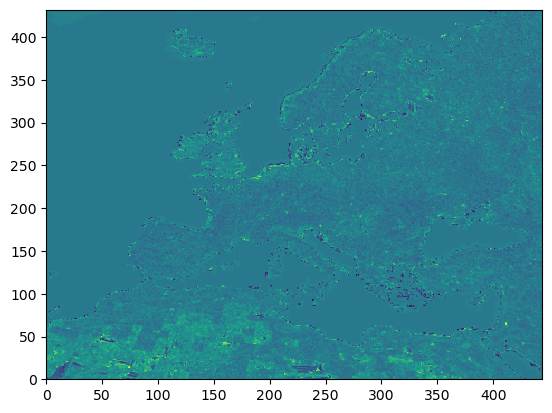

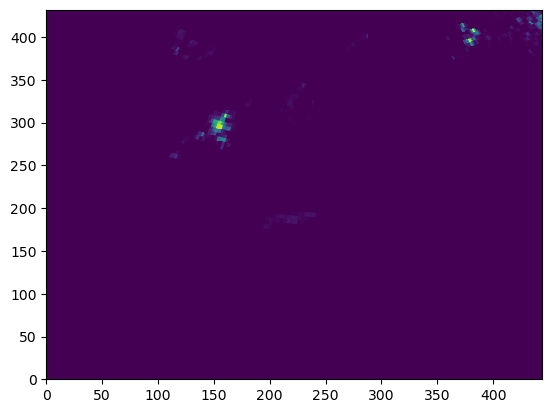

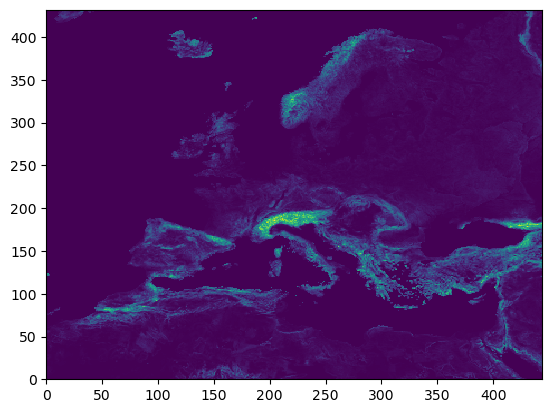

In [55]:
plt.figure()
plt.pcolormesh(data.FMAX.values)

plt.figure()
plt.pcolormesh(data.peatf.values)

plt.figure()
plt.pcolormesh(data.SLOPE.values)


In [16]:
print('mineral, mm/s:')
print(0.0070556 *( 10.**(-0.813+0.015*0) ))
print(0.0070556 *( 10.**(-0.813+0.015*100) ))
print('organic, mm/s:')
print(1e-4)
print(2.8e-4 * 1e3)

print('mineral, sucsat [mm]:')
psis_intercept = 1.873
psis_slope = -0.013
print(10 *( 10.**(psis_intercept+psis_slope*0) ))
print(10 *( 10.**(psis_intercept+psis_slope*100) ))


mineral, mm/s:
0.0010852603880122094
0.03431894680476677
organic, mm/s:
0.0001
0.27999999999999997
mineral, sucsat:
746.4487584100665
37.41105882720533


<xarray.DataArray 'Qh' (time: 1, lat: 432, lon: 444)>
array([[[ 43.922653,  41.731815,  41.280006, ...,        nan,
                nan,        nan],
        [ 41.845406,  42.395203,  40.99896 , ...,        nan,
                nan,        nan],
        [ 38.047962,  40.77057 ,  40.551807, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ..., -30.806566,
         -27.78897 , -23.153742],
        [       nan,        nan,        nan, ..., -43.150826,
         -30.085913, -25.616865],
        [       nan,        nan,        nan, ..., -43.08416 ,
         -41.52945 , -35.194477]]], dtype=float32)
Coordinates:
  * time     (time) object 2019-05-19 12:00:00
  * lon      (lon) float32 349.4 349.5 349.6 349.7 ... 36.83 36.94 37.04 37.15
  * lat      (lat) float32 20.58 20.68 20.78 20.88 ... 59.95 60.02 60.09 60.16
Attributes:
    long_name:     sensible heat
    units:         W/m^2
    cell_methods:  time: mean

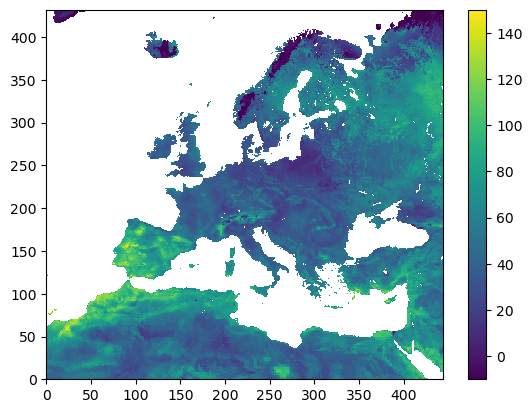

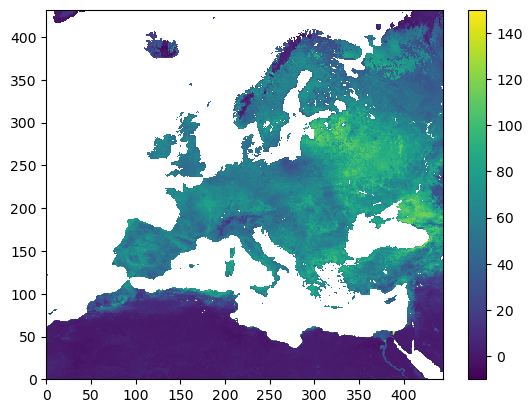

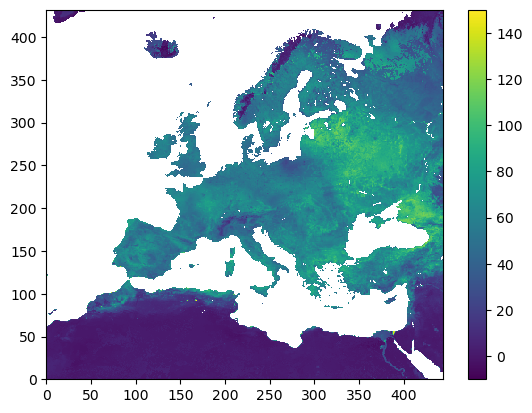

In [28]:
%matplotlib inline
plt.figure()
plt.pcolormesh(data.Qh[0],vmin=-10,vmax=150)
plt.colorbar()

data.Qh

plt.figure()
plt.pcolormesh(data.Qle[0],vmin=-10,vmax=150)
plt.colorbar()

plt.figure()
plt.pcolormesh(data.QFLX_EVAP_TOT[0]*2.45e6,vmin=-10,vmax=150)
plt.colorbar()

data.Qh

NameError: name 'dates' is not defined

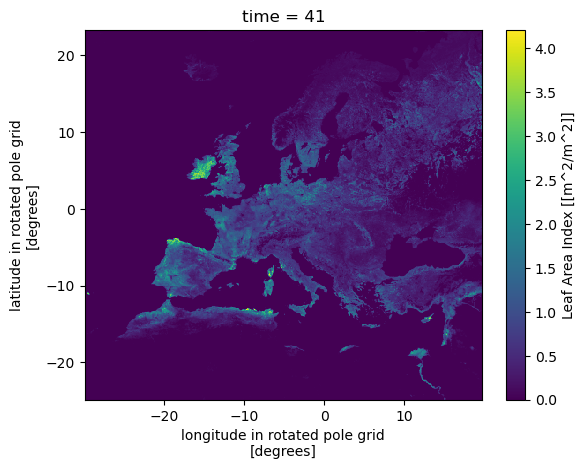

In [97]:
%matplotlib inline
data = xr.open_dataset('/p/largedata2/detectdata/CentralDB/projects/d05/working_directory/data_LAI/12km/lai_8-day_EUR11_2019.nc')
data2 = xr.open_dataset('/p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v10_loc50/input_clm/surfdata_EUR-11_hist_16pfts_Irrig_CMIP6_simyr2000_c230808_GLC2000.nc')
data3 = xr.open_dataset('/p/largedata2/detectdata/CentralDB/projects/d05/working_directory/data_LAI/12km/lai_8-day_EUR11_2020.nc')


LAI_w = ((data2.PCT_NAT_PFT.values/100)*data2.MONTHLY_LAI[0,0:15]).sum(axis=0)

i_ = 5
plt.figure()
data.lai[i_].plot.pcolormesh()
plt.title('%s'%dates[i_])

i_ = 5
plt.figure()
data3.lai[i_].plot.pcolormesh()
plt.title('%s'%dates[i_])

plt.figure()
LAI_w.plot.pcolormesh()
# plt.title(('%s'%data3.pftname[i].values).split("'")[1].split("'")[0])


/tmp/ipykernel_7643/2424004552.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


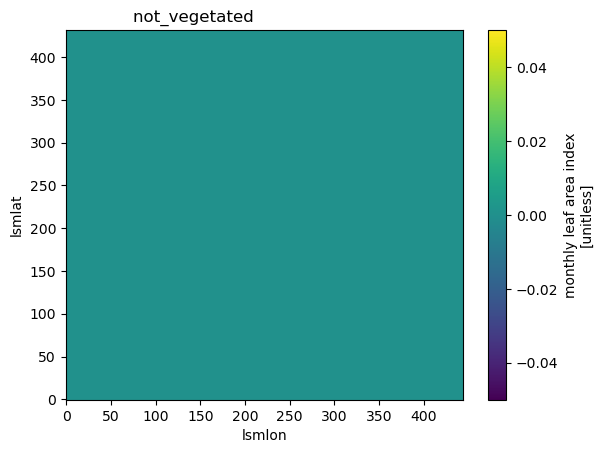

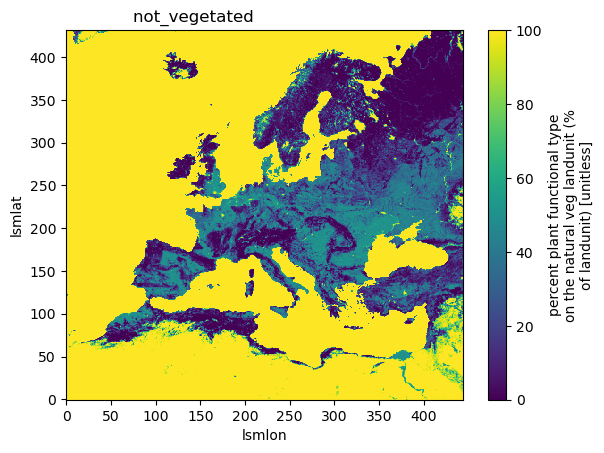

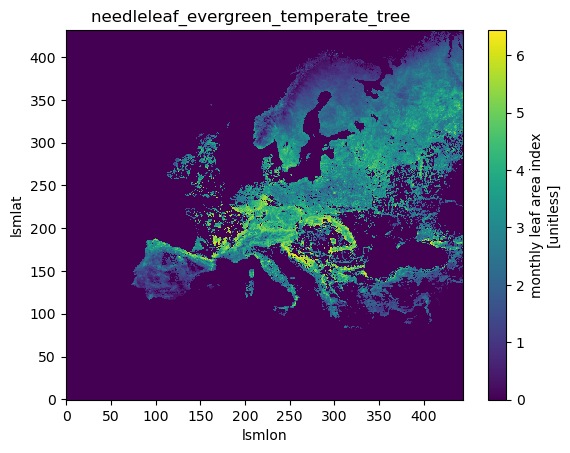

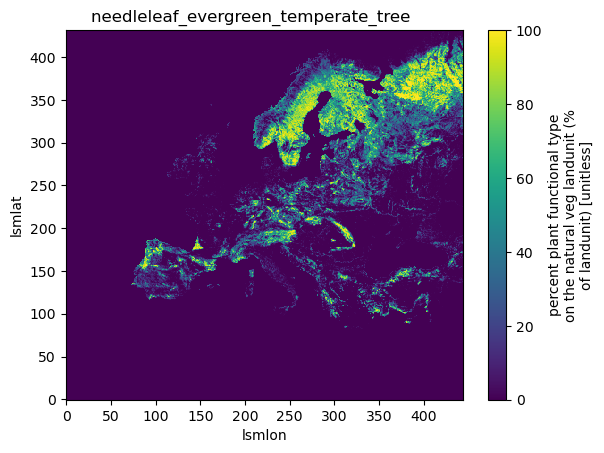

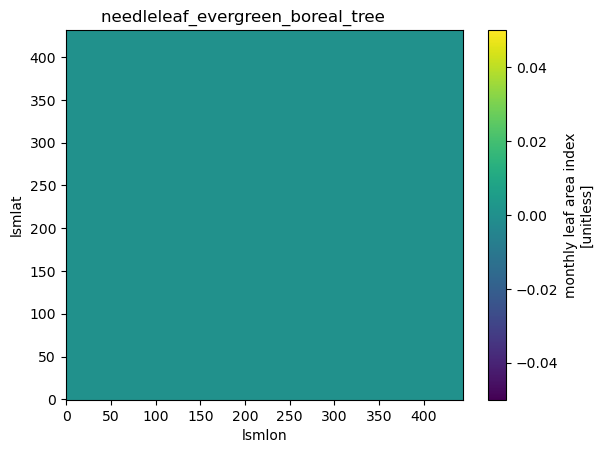

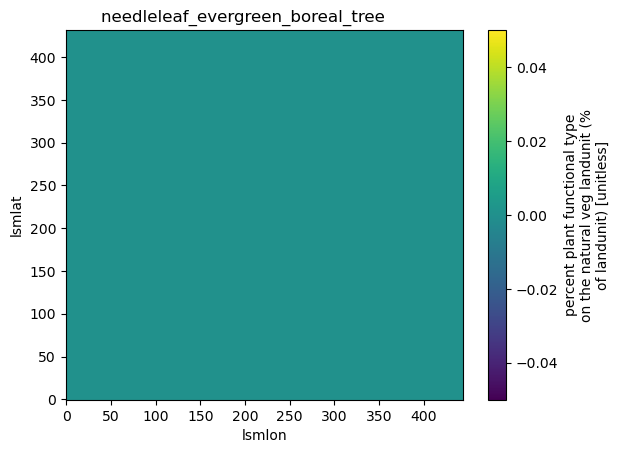

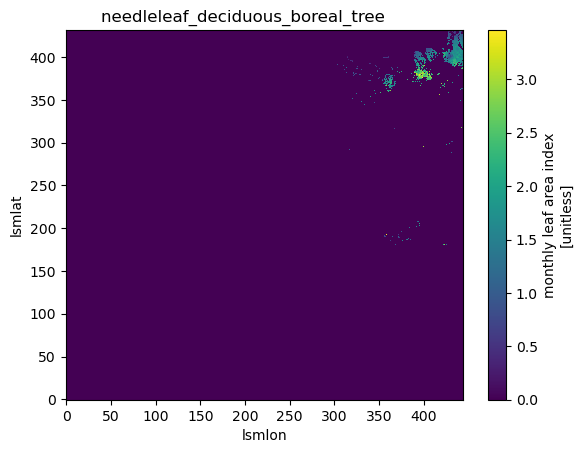

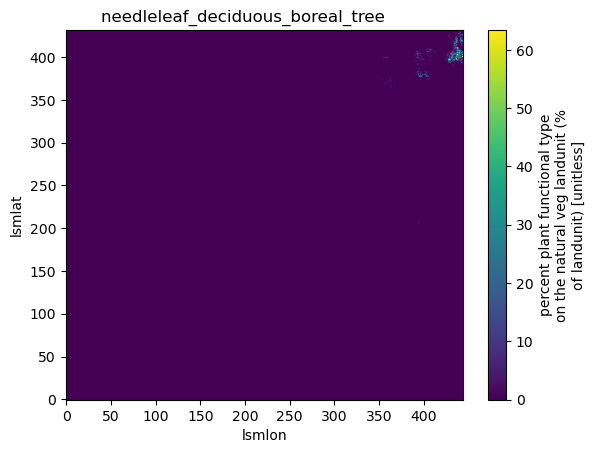

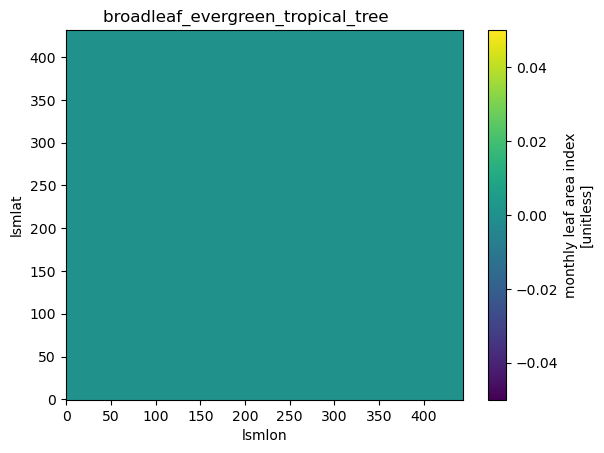

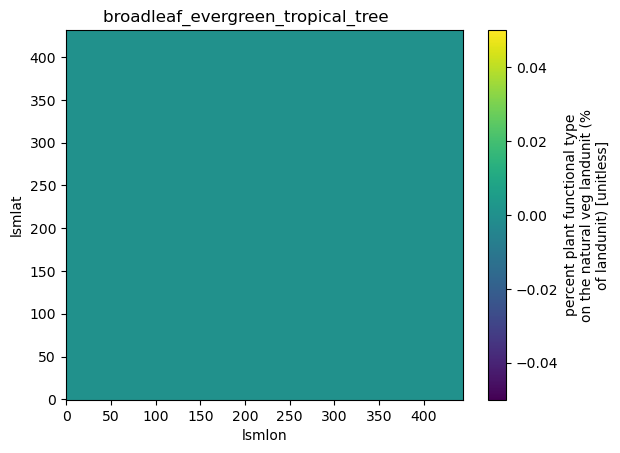

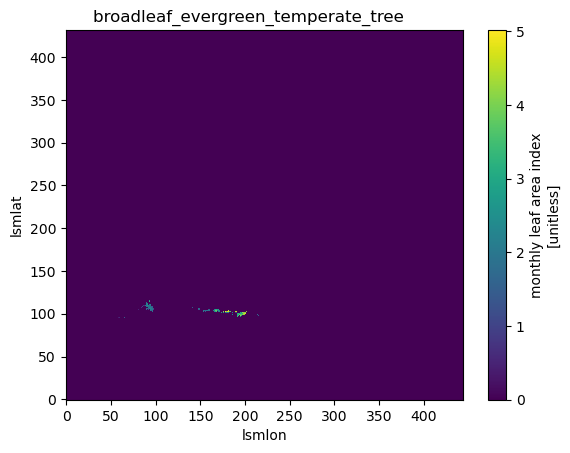

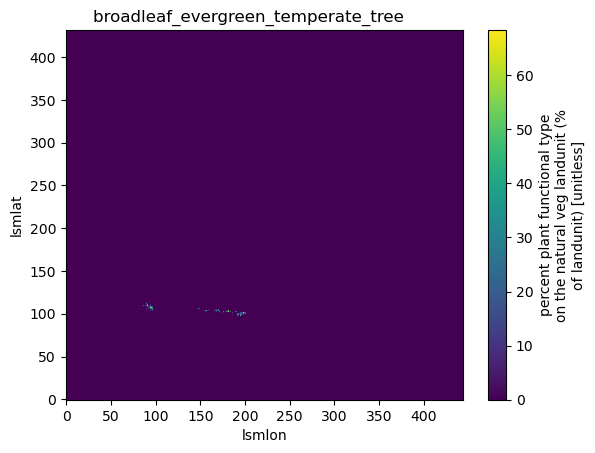

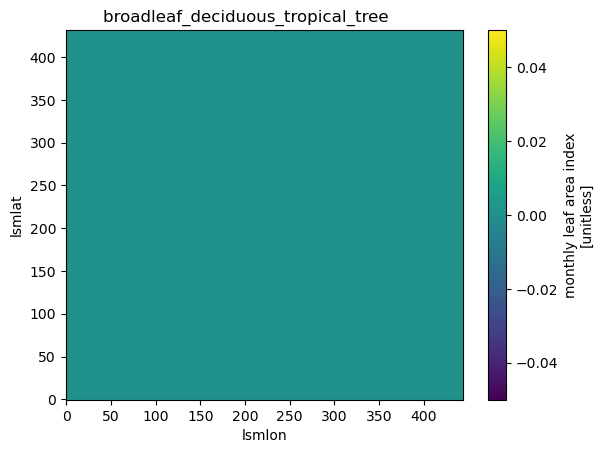

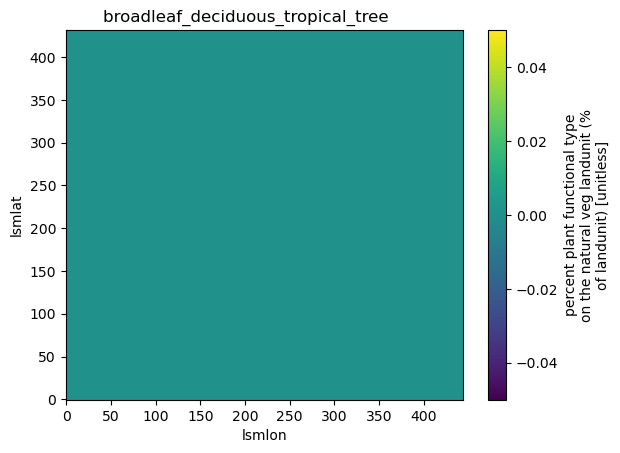

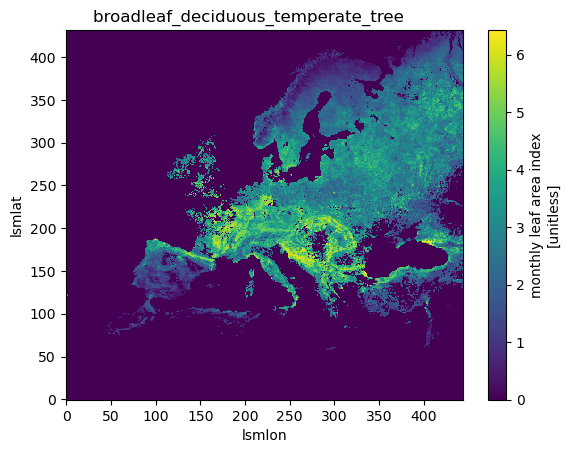

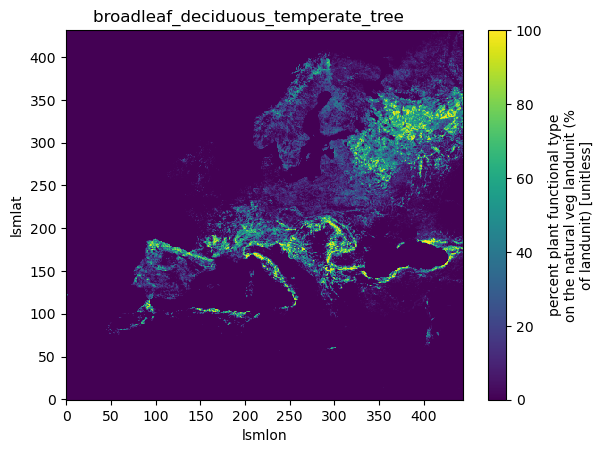

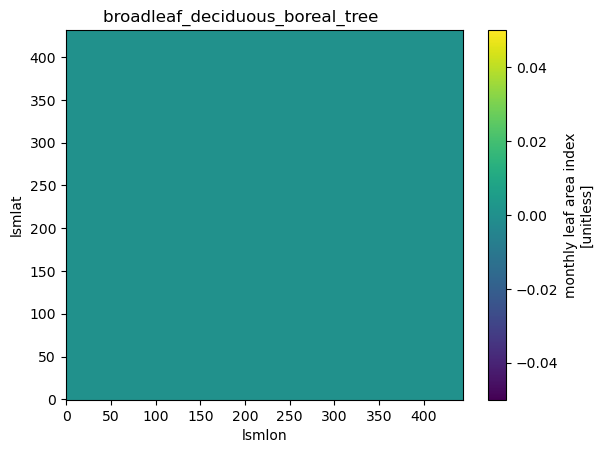

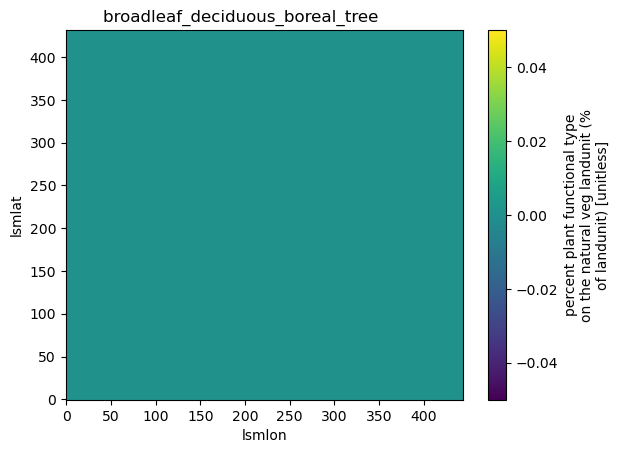

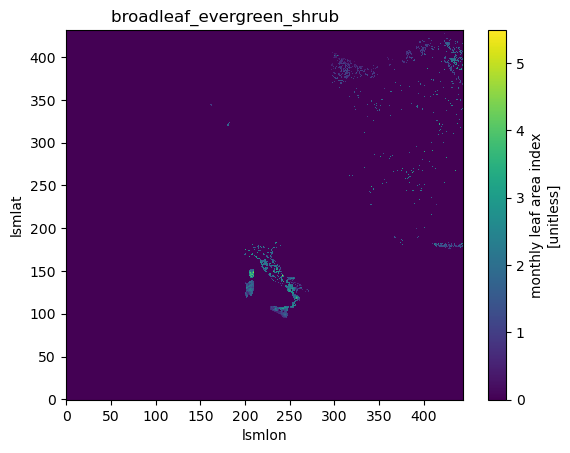

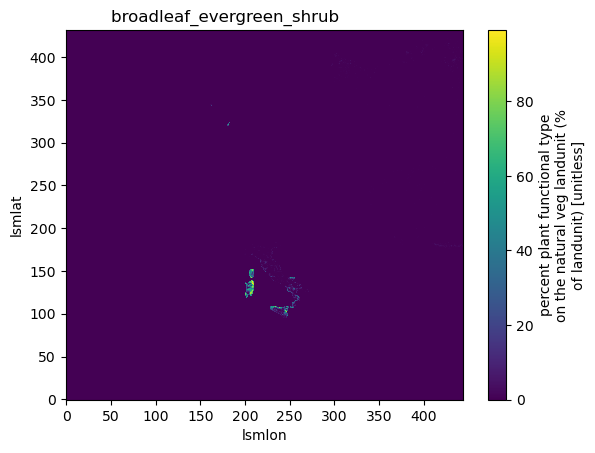

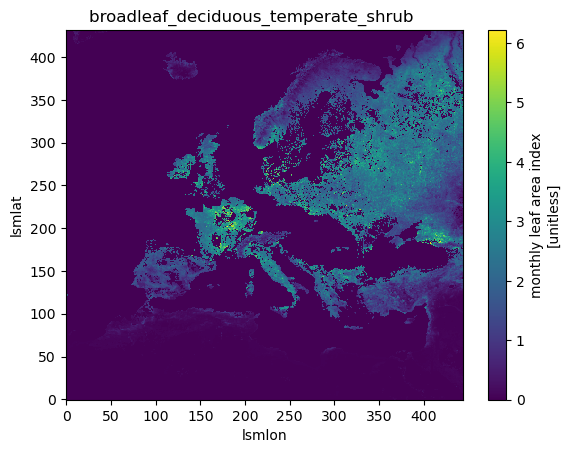

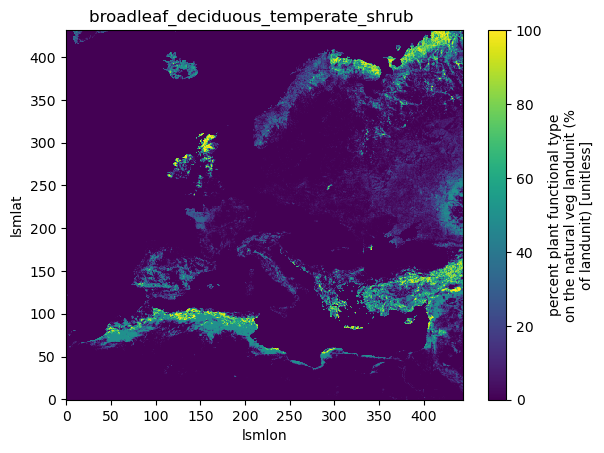

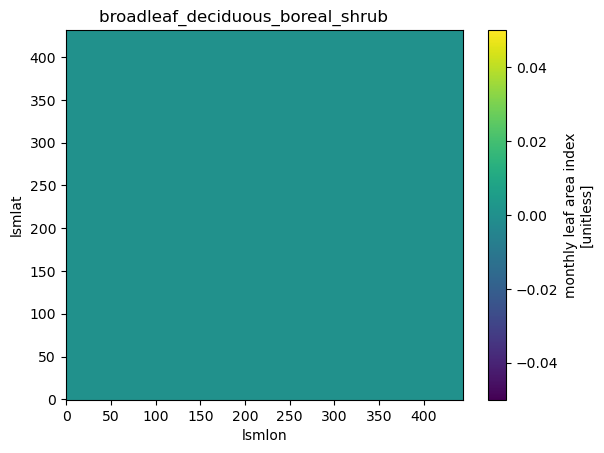

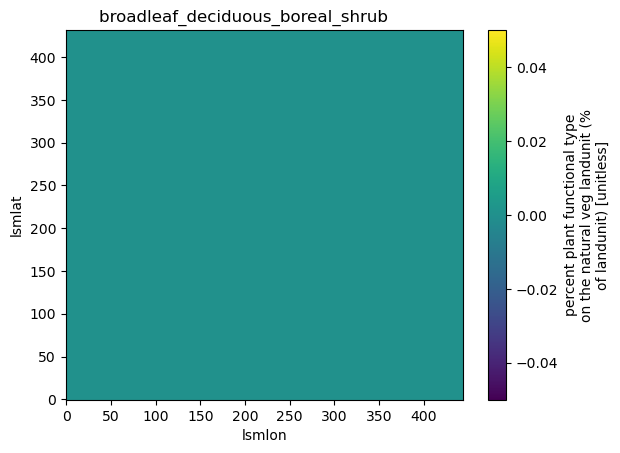

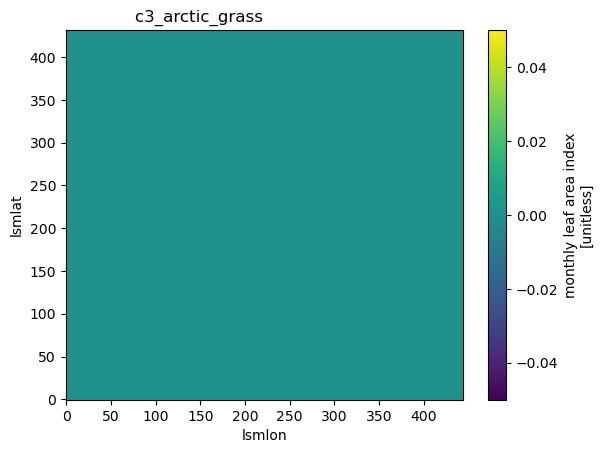

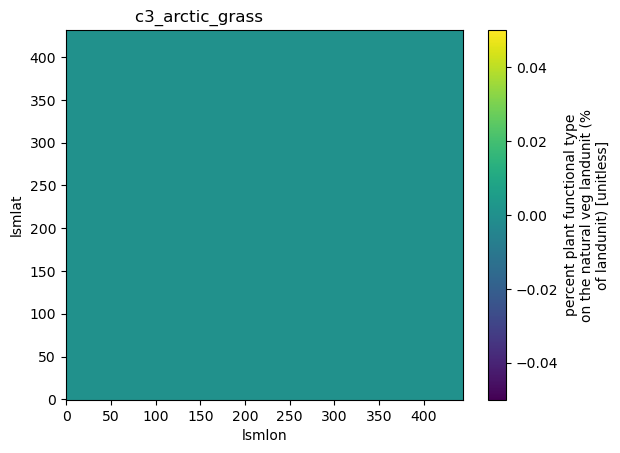

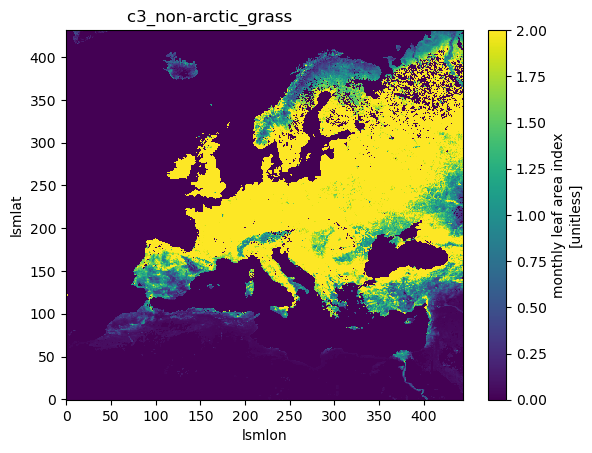

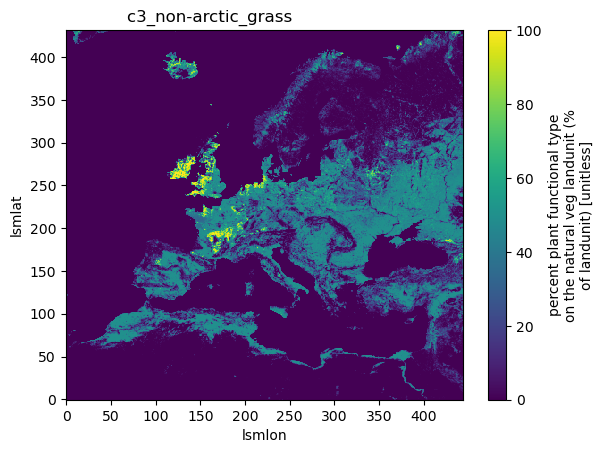

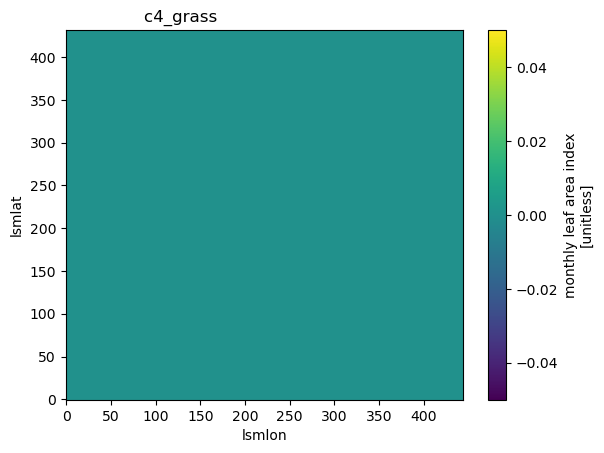

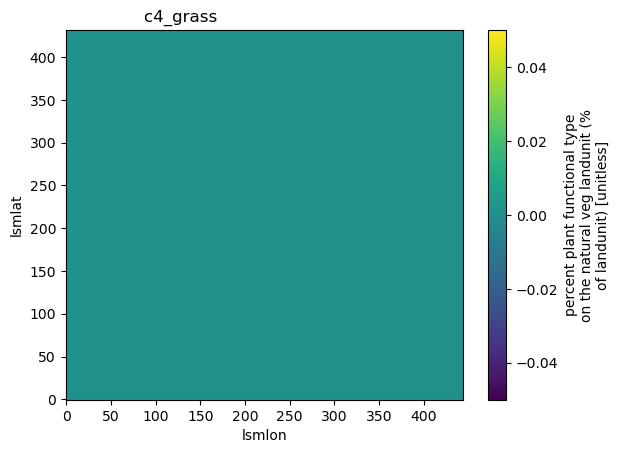

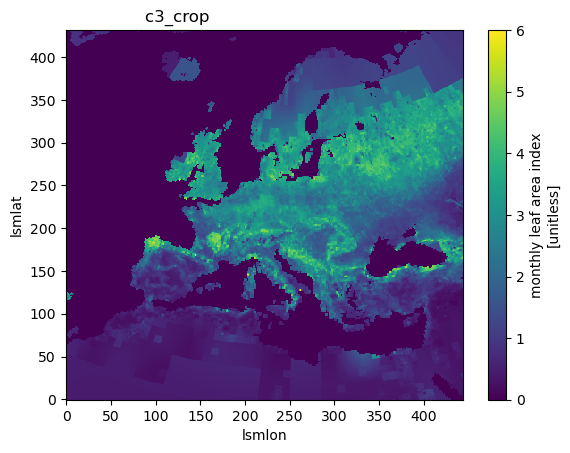

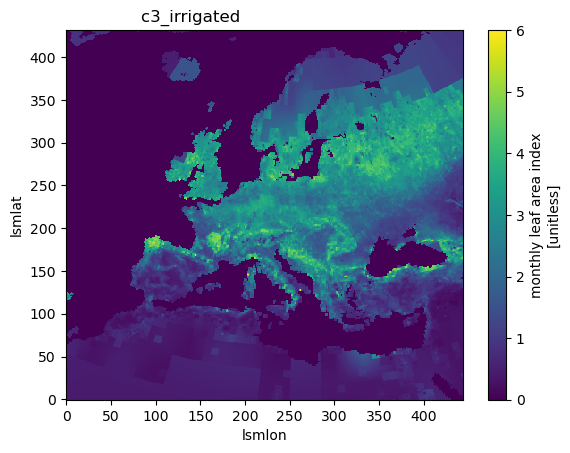

In [43]:
for i in range(17):
    plt.figure()
    data2.MONTHLY_LAI[5,i].plot.pcolormesh()
    plt.title(('%s'%data3.pftname[i].values).split("'")[1].split("'")[0])
    
    if i < 15:
        plt.figure()
        data2.PCT_NAT_PFT[i].plot.pcolormesh()
        plt.title(('%s'%data3.pftname[i].values).split("'")[1].split("'")[0])

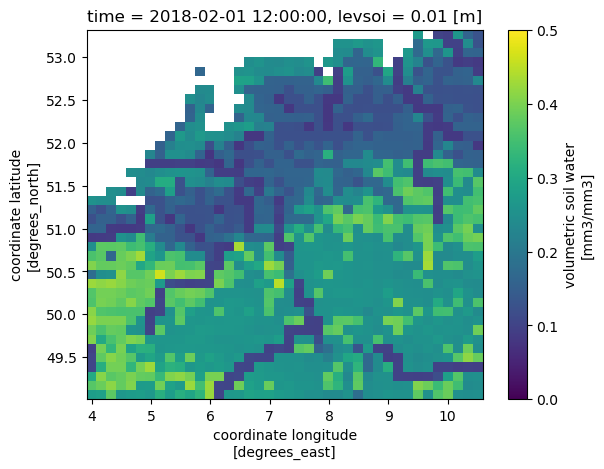

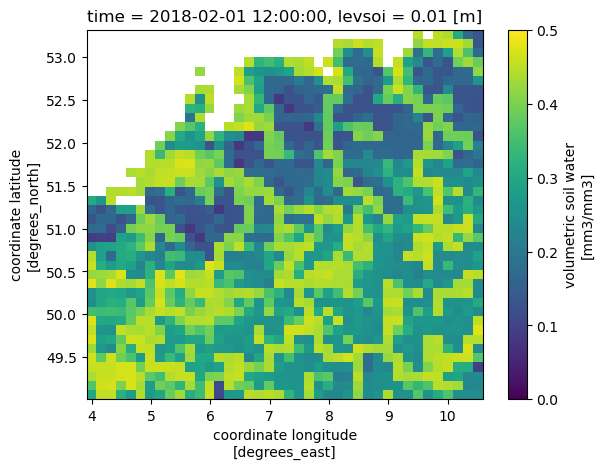

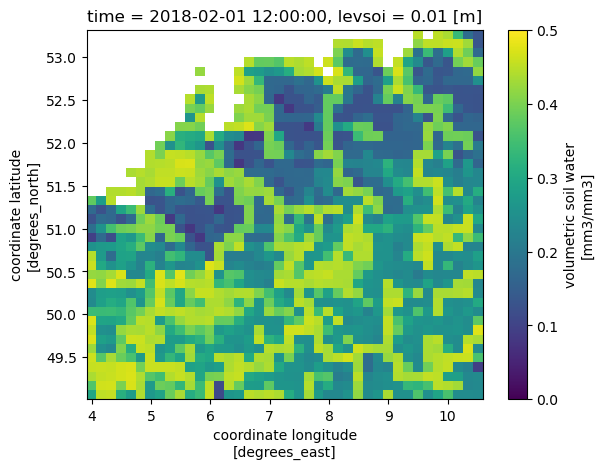

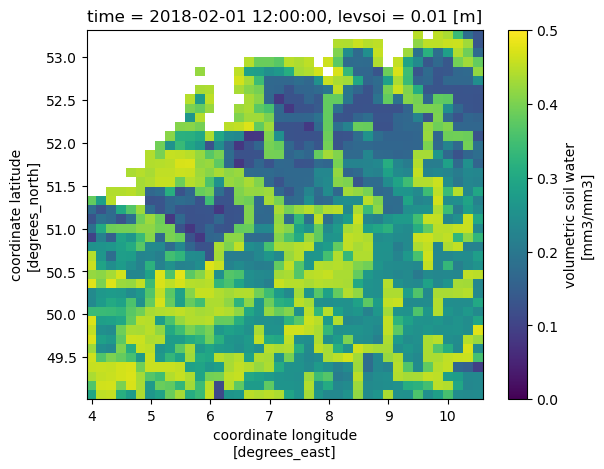

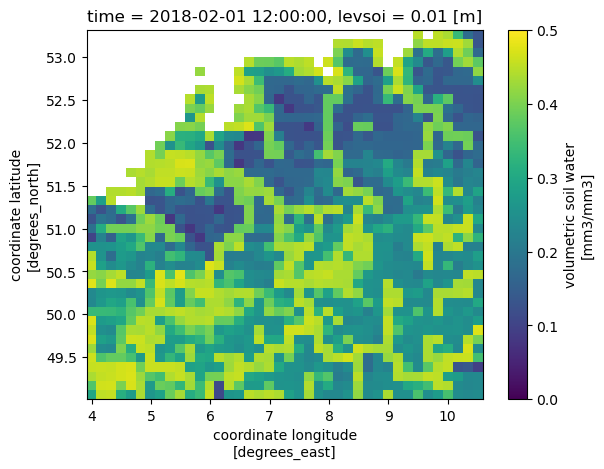

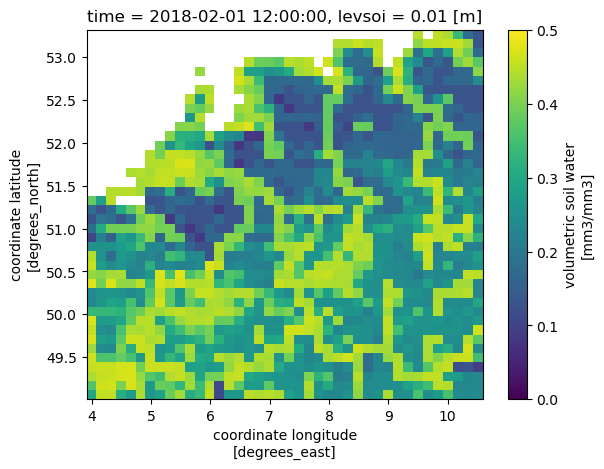

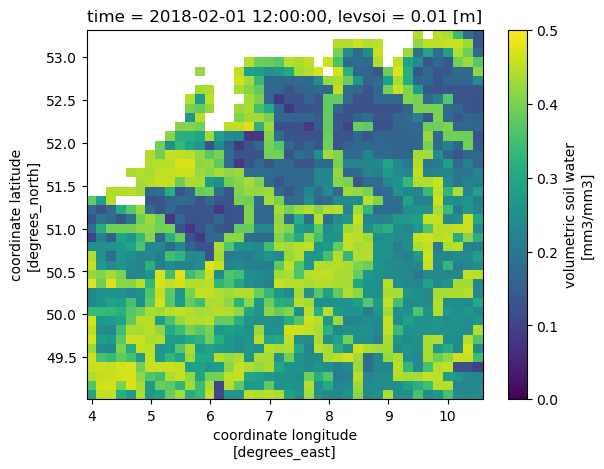

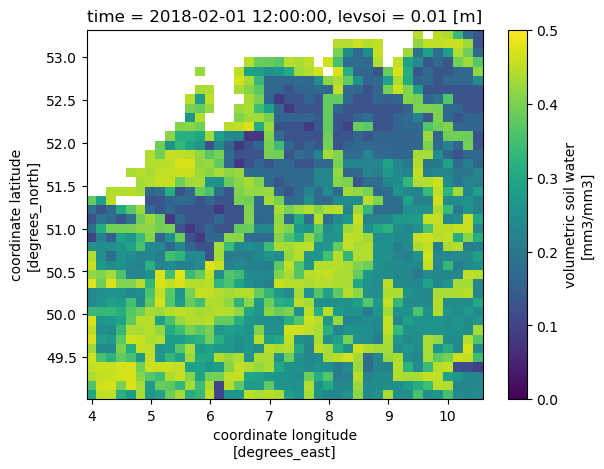

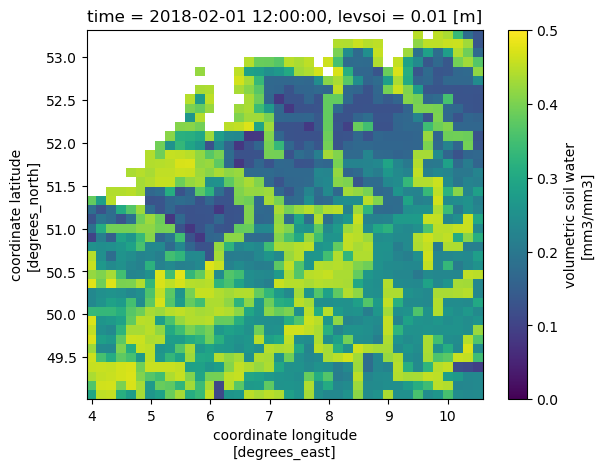

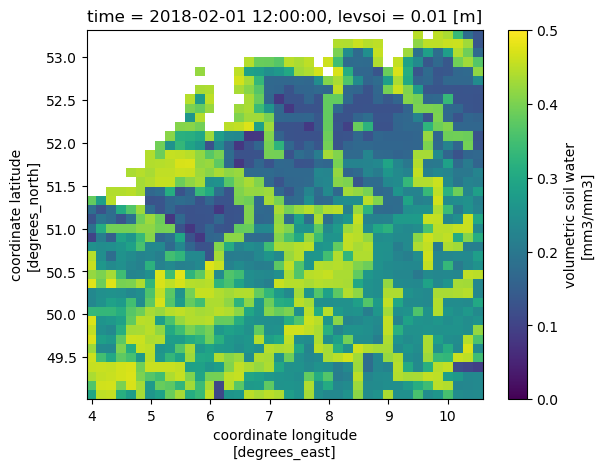

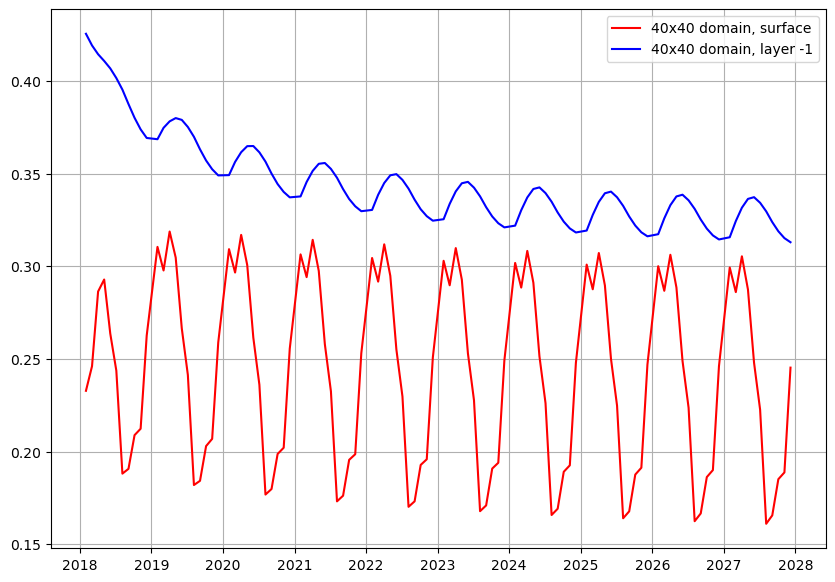

In [7]:
%matplotlib inline

val_111_surf = {}
val_111_deep = {}
dates_111 = {}
i_levsoi_surf = 0
i_levsoi_deep = -1

# for i_ in i_ens:
i_ = 0
val_111_surf[i_]=[]
val_111_deep[i_]=[]
dates_111[i_]=[]

for add_year in np.arange(0,10):

    files_clm = sorted(glob(os.path.join('/p/scratch/cjibg36/kaandorp2/TSMP_results/TSMP_patched',
                                         'tsmp_cordex_40x40_spinup/**/run_%3.3i_*/clm.clm2.h0*'%(add_year)) ) )

    for i2,file_clm in enumerate(files_clm):
        date = pd.to_datetime(os.path.basename(file_clm).split('h0.')[1].split('.nc')[0][0:10]) + timedelta(hours=12) + timedelta(days=(365*int(add_year)))
        data = xr.open_dataset(file_clm)

        dates_111[i_].append(date)
        val_111_surf[i_].append(float(data.H2OSOI[0,i_levsoi_surf].mean()))
        val_111_deep[i_].append(float(data.H2OSOI[0,i_levsoi_deep].mean()))


        if i2%12==0:

            plt.figure()
            data.H2OSOI[0,0].plot.pcolormesh(vmin=0,vmax=.5)

                
styles = ['-','--',':','-.','-']
markers = [None,None,None,None,'d']
plt.figure(figsize=(10,7))

# for i_,name_ in enumerate(i_ens):

name_ = '40x40 domain'
if i_ == 0:
    label_1 = name_ + ', surface'
    label_2 = name_ + ', layer -1'
else:
    label_1 = None
    label_2 = None
        
plt.plot(dates_111[i_],val_111_surf[i_],'r',linestyle=styles[i_],marker=markers[i_],label=label_1)
plt.plot(dates_111[i_],val_111_deep[i_],'b',linestyle=styles[i_],marker=markers[i_],label=label_2)
plt.grid(which='both')
plt.legend()


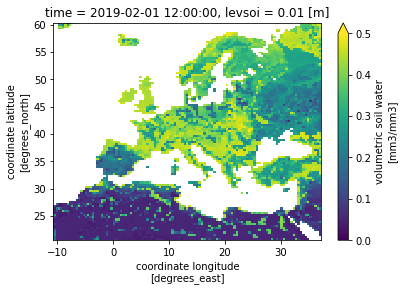

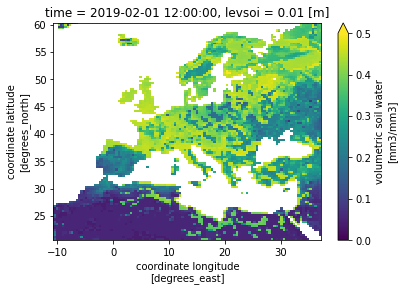

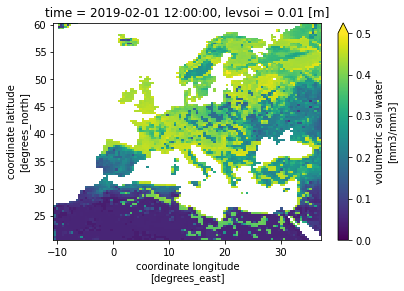

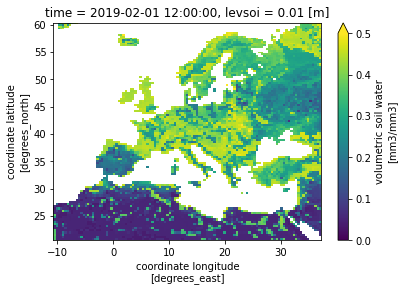

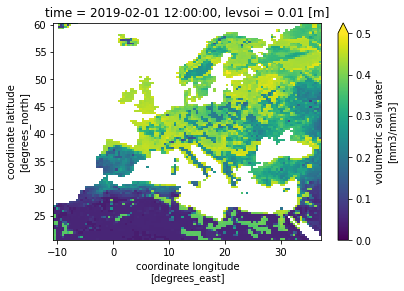

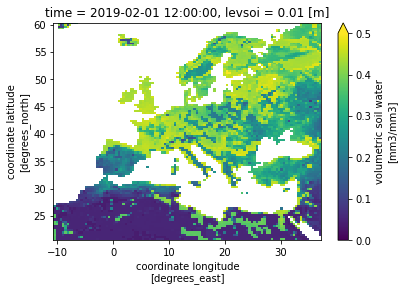

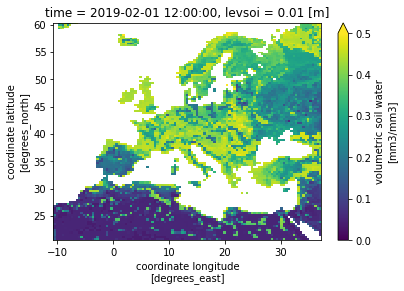

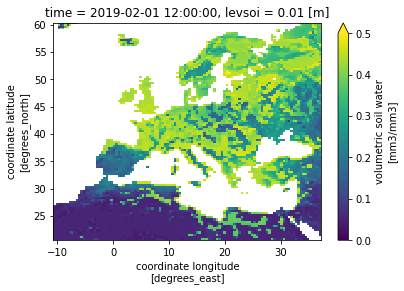

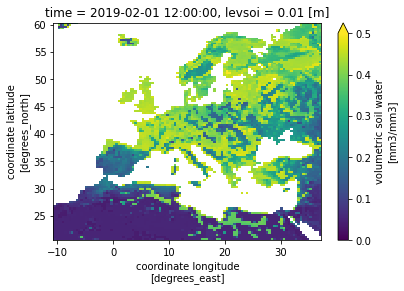

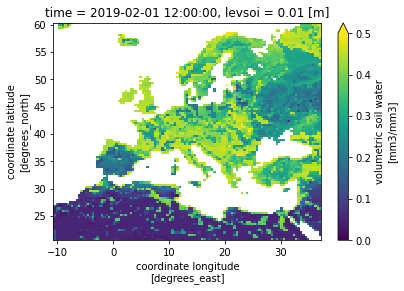

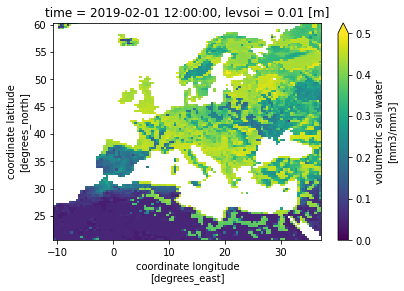

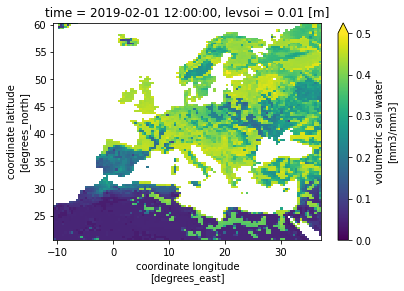

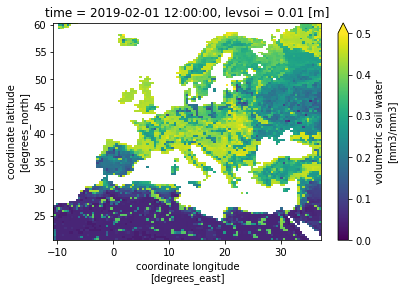

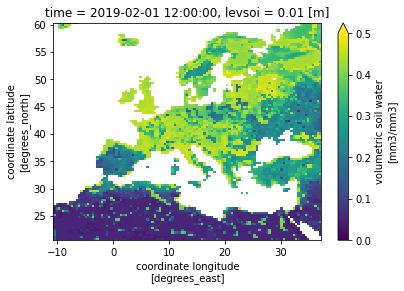

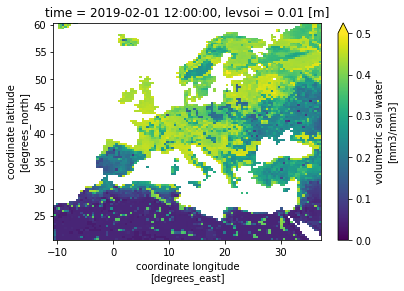

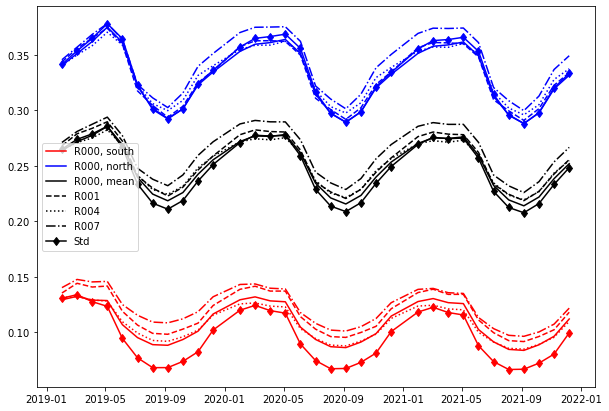

In [5]:
%matplotlib inline
# plot how ensemble member diverge
i_ens = ['R000','R001','R004','R007','Std']
val_111 = {}
val_111_s = {}
val_111_n = {}
dates_111 = {}
i_levsoi = 0

for i_ in i_ens:
    val_111[i_]=[]
    val_111_s[i_]=[]
    val_111_n[i_]=[]
    dates_111[i_]=[]
    
    for add_year in np.arange(0,3):

        files_clm = sorted(glob(os.path.join('/p/scratch/cjibg36/kaandorp2/TSMP_results/TSMP_patched',
                                             'tsmp_cordex_111x108_spinup_Ks%s/**/run_%3.3i_*/clm.clm2.h0*'%(i_,add_year)) ) )

        for i2,file_clm in enumerate(files_clm):
            date = pd.to_datetime(os.path.basename(file_clm).split('h0.')[1].split('.nc')[0][0:10]) + timedelta(hours=12) + timedelta(days=(365*int(add_year)))
            data = xr.open_dataset(file_clm)

            dates_111[i_].append(date)
            val_111[i_].append(float(data.H2OSOI[0,i_levsoi].mean()))
            val_111_s[i_].append(float(data.H2OSOI[0,i_levsoi].where(data.lat < 33).mean()))
            val_111_n[i_].append(float(data.H2OSOI[0,i_levsoi].where(data.lat > 33).mean()))
    
            
            if i2%12==0:
                
                plt.figure()
                data.H2OSOI[0,0].plot.pcolormesh(vmin=0,vmax=.5)
                # plt.title('Member %s, %s' % (i_,date) )
                
styles = ['-','--',':','-.','-']
markers = [None,None,None,None,'d']
plt.figure(figsize=(10,7))

for i_,name_ in enumerate(i_ens):


    if i_ == 0:
        label_1 = name_ + ', south'
        label_2 = name_ + ', north'
        label_3 = name_ + ', mean'
    else:
        label_1 = None
        label_2 = None
        label_3 = name_
        
    plt.plot(dates_111[name_],val_111_s[name_],'r',linestyle=styles[i_],marker=markers[i_],label=label_1)
    plt.plot(dates_111[name_],val_111_n[name_],'b',linestyle=styles[i_],marker=markers[i_],label=label_2)
    plt.plot(dates_111[name_],val_111[name_],'k',linestyle=styles[i_],marker=markers[i_],label=label_3)
    
plt.legend()

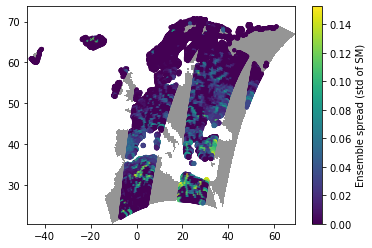

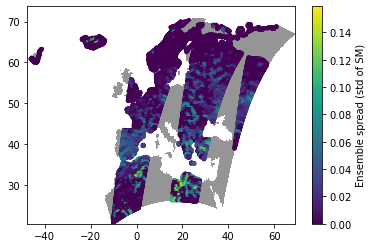

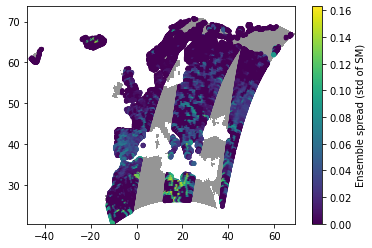

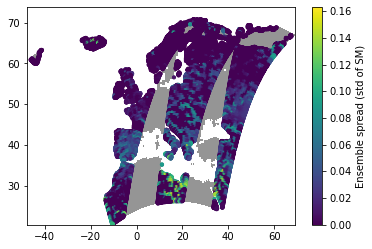

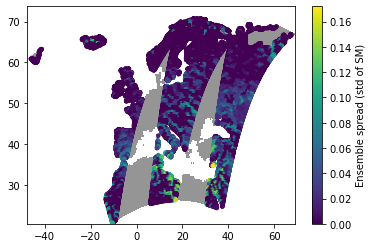

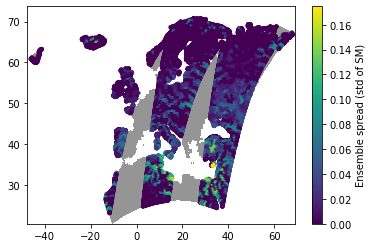

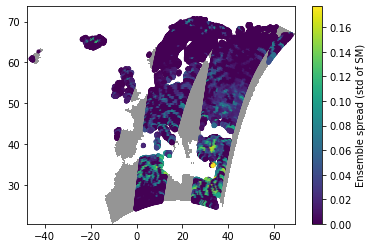

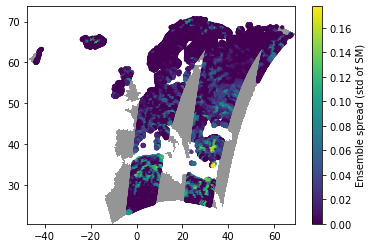

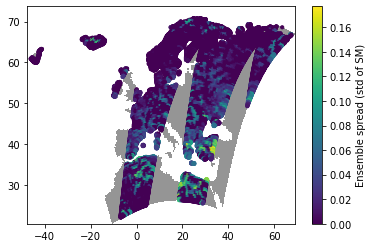

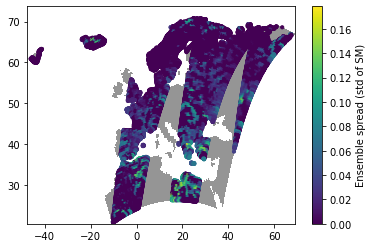

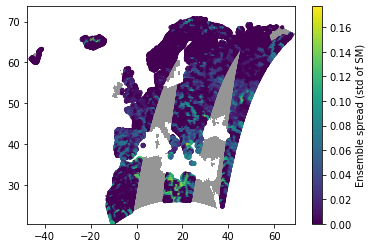

In [89]:
results_ensemble = {}
for i in range(1,n_ensemble):
    operator.interpolate_model_results(i,settings_run)
    results_n = operator.data_TSMP_i
    
    for date_ in results_n.keys():
        if i == 1:
            results_ensemble[date_] = results_n[date_]
        else:
            results_ensemble[date_] = np.vstack((results_ensemble[date_],results_n[date_]))
            
for date_ in results_ensemble.keys():
    
    plt.figure()
    plt.pcolormesh(operator.grid_TSMP['lon_corner'],operator.grid_TSMP['lat_corner'],operator.grid_TSMP['lsm']==2,cmap=plt.cm.Greys,vmax=2 )
    std = results_ensemble[date_].std(axis=0)
    plt.scatter(operator.lons_out[date_],operator.lats_out[date_],s=10,c=std,cmap=plt.cm.viridis)
    cbar = plt.colorbar()
    cbar.set_label('Ensemble spread (std of SM)')
    # plt.savefig(os.path.join(settings_run['dir_figs'],'mismatch_%s_%3.3i.png'%(str_date,settings_gen['i_iter']) ) )


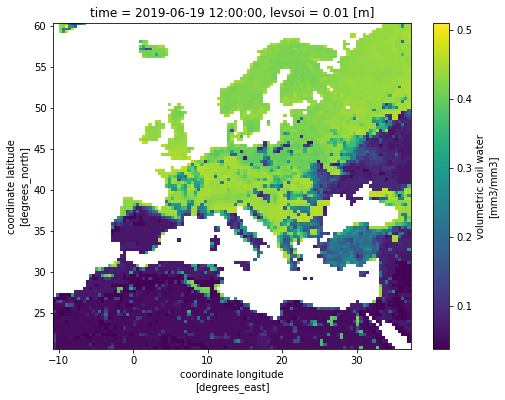

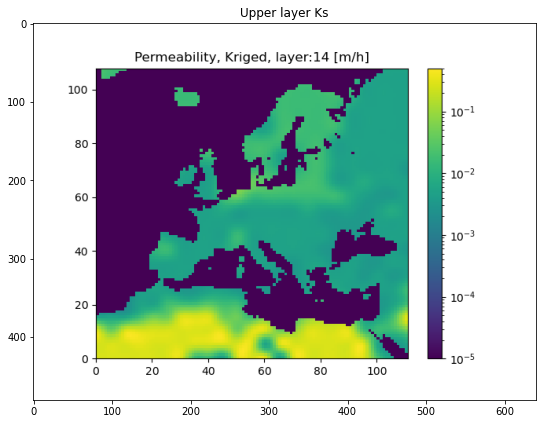

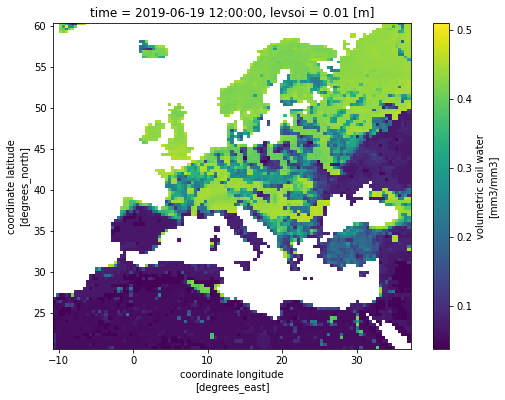

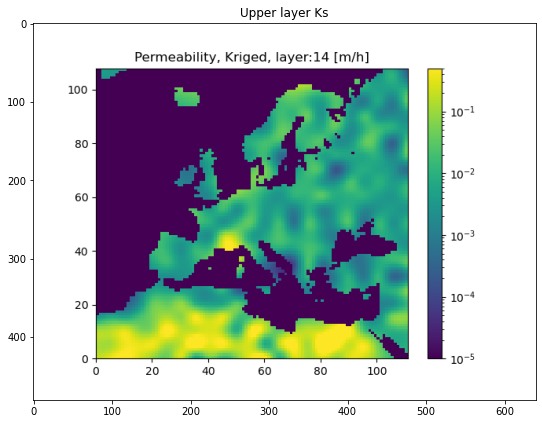

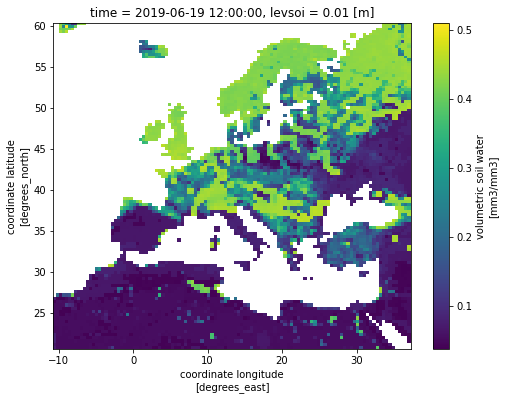

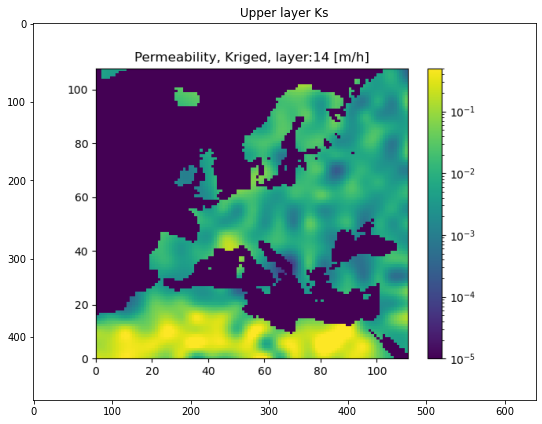

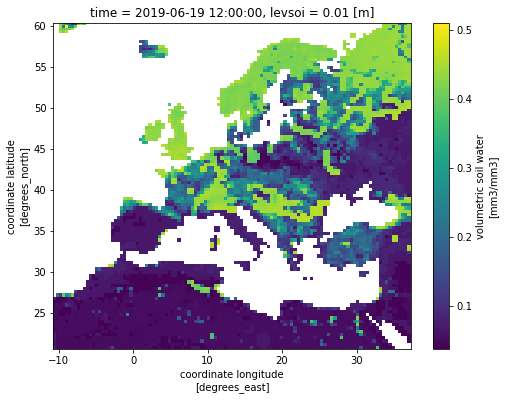

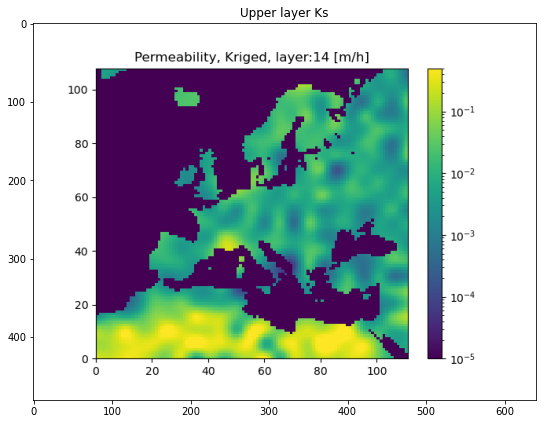

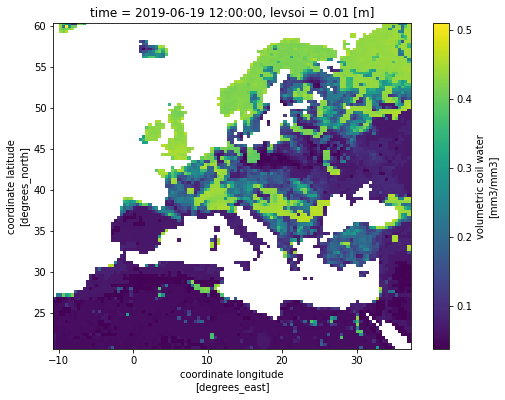

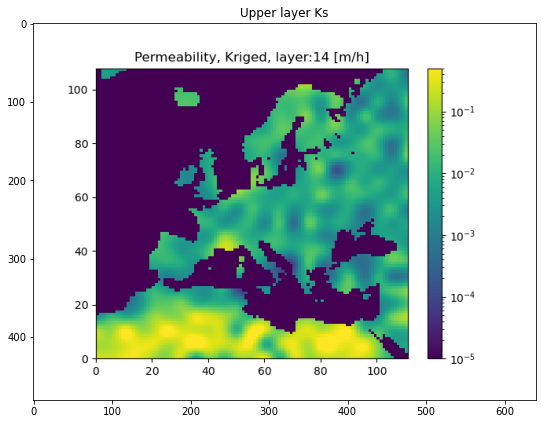

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

figures_Ks = sorted(glob(os.path.join(dir_date,'**/R000/figures/Ks_real000_014.png')))
data_clm = sorted(glob(os.path.join(dir_date,'**/R000/**/clm.clm2.h0.2019-06-19-43200.nc'))) 

for i1,data_ in enumerate(data_clm):
    data = xr.open_dataset(data_)
    plt.figure(figsize=(8,6))
    data.H2OSOI[0,0].plot.pcolormesh()

    fig_ = figures_Ks[i1]
    plt.figure(figsize=(9,9))
    image = plt.imread(fig_)
    plt.imshow(image)
    plt.title('Upper layer Ks')
    plt.show()    
    
    